# Archaic admixture in swept and non-swept haplotypes and regions

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}


def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

## Sweep and admixture data

In [9]:
admix_windows_chrX = pandas.read_hdf(results_dir / 'male_x_admix_windows.hdf')
admix_windows_chrX.head()

chrom            name   start     end  nr_admix_tracts  tot_admix_len  \
0     X  B_Australian-4       0  100000                0              0   
1     X  B_Australian-4  100000  200000                0              0   
2     X  B_Australian-4  200000  300000                0              0   
3     X  B_Australian-4  300000  400000                0              0   
4     X  B_Australian-4  400000  500000                0              0   

   archaic_snps  altai_snps  denisova_snps  vindija_snps  mean_post_prob  \
0           NaN         NaN            NaN           NaN             NaN   
1           NaN         NaN            NaN           NaN             NaN   
2           NaN         NaN            NaN           NaN             NaN   
3           0.0         0.0            0.0           0.0             NaN   
4           0.0         0.0            0.0           0.0             NaN   

   admix_prop  level_1  bases_analyzed  
0         NaN        0            1337  
1         NaN        1            5045  
2         NaN        2            9875  
3         0.0        3           26649  
4         0.0        4           22968

In [10]:
(admix_windows_chrX.admix_prop.isnull()).sum()

43820

In [11]:
admix_windows_chrX_full = pandas.read_hdf(results_dir / 'male_x_admix_windows_full.hdf')
admix_windows_chrX_full.head()

chrom            name   start     end  nr_admix_tracts  tot_admix_len  \
0     X  B_Australian-4       0  100000                0              0   
1     X  B_Australian-4  100000  200000                0              0   
2     X  B_Australian-4  200000  300000                0              0   
3     X  B_Australian-4  300000  400000                0              0   
4     X  B_Australian-4  400000  500000                0              0   

   mean_post_prob  admix_prop  level_1  bases_analyzed  
0             NaN         NaN        0            1602  
1             NaN         NaN        1            6492  
2             NaN         NaN        2           14598  
3             NaN         0.0        3           37371  
4             NaN         0.0        4           31532

In [12]:
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

# analysis without repeats
merged_data = (sweep_data.merge(admix_windows_chrX, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

# analysis including repeats
merged_data_full = (sweep_data.merge(admix_windows_chrX_full, how='left',
                                right_on=['name', 'start', 'end'], 
                                left_on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )

In [13]:
df = merged_data[['name', 'start', 'admix_prop']].merge(merged_data_full[['name', 'start', 'admix_prop']], 
                                                   on=['name', 'start'], how='outer')

In [14]:
((~df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum(), 
 (df.admix_prop_x.isnull() & ~df.admix_prop_y.isnull()).sum())

(169377, 23766)

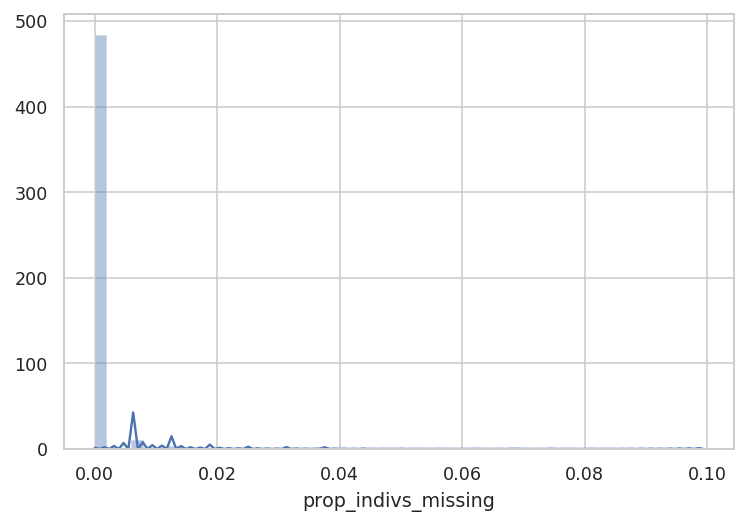

In [15]:
g = sns.distplot(merged_data.prop_indivs_missing)

## Global admixture proportions

In [16]:
merged_data.loc[lambda df: df.region_1 != 'Africa', 'admix_prop'].mean()

0.008050443684797818

In [17]:
merged_data.groupby('region_1')['admix_prop'].mean()

region_1
Africa                     NaN
WestEurasia           0.006498
SouthAsia             0.008298
CentralAsiaSiberia    0.004931
Oceania               0.014618
EastAsia              0.008455
America               0.005812
Name: admix_prop, dtype: float64

In [18]:
merged_data.head()

indiv_1    start      end       pop_1 region_label_1  region_id_1  \
27  B_Australian-4  2700000  2800000  Australian        Oceania            4   
28  B_Australian-4  2800000  2900000  Australian        Oceania            4   
29  B_Australian-4  2900000  3000000  Australian        Oceania            4   
30  B_Australian-4  3000000  3100000  Australian        Oceania            4   
31  B_Australian-4  3100000  3200000  Australian        Oceania            4   

   region_1  mean_dist  mean_dist_af  mean_dist_to_africans       ...        \
27  Oceania   0.001051      0.001051               0.001735       ...         
28  Oceania   0.000633      0.000623               0.001109       ...         
29  Oceania   0.000377      0.000318               0.000844       ...         
30  Oceania   0.001087      0.001087               0.001078       ...         
31  Oceania   0.001212      0.001205               0.001544       ...         

    nr_admix_tracts  tot_admix_len  archaic_snps  altai_snps  denisova_snps  \
27              0.0            0.0           0.0         0.0            0.0   
28              0.0            0.0           0.0         0.0            0.0   
29              0.0            0.0           0.0         0.0            0.0   
30              0.0            0.0           0.0         0.0            0.0   
31              0.0            0.0           0.0         0.0            0.0   

    vindija_snps  mean_post_prob  admix_prop  level_1  bases_analyzed  
27           0.0             NaN         0.0     27.0         31236.0  
28           0.0             NaN         0.0     28.0         27918.0  
29           0.0             NaN         0.0     29.0         31151.0  
30           0.0             NaN         0.0     30.0         41200.0  
31           0.0             NaN         0.0     31.0         45155.0  

[5 rows x 47 columns]

## Assess how well admixture filtering works

Only a small number of extra windows are called as swept when we do admixture filtering:

In [19]:
(merged_data.swept_af == True).sum() - (merged_data.swept == True).sum()

18

ECHs are only called when five consequtive 100kb windows each contain more than XXX called bases. To allow calling of ECHs in the same set of windows after admixed segments are masked out, we do not remove windows that fall below this cutoff after masking. The reduced number of bases in windows will increase the variance in estimated distances. Increased variance is expected to reduce sensitivity and specificity equally and is not expected to bias inferende in any direction. 

However, a distance cannot be computed when for windows where an admixed sergments span a 100kb window. To accomodate this additional missing data, we allow an estimated distance to be missing in two out of five consequtive 100kb windows when we call ECHs on admixture masked data.

In cases where more than two in five windows are nan, we cannot call ECHs. 

In how many windows does that happen? I.e. windows where mean_dist was not nan without masking but nan with admix filtering:

In [20]:
new_uncallable_when_admix_filtered = (merged_data
                                  .loc[
                                       ~merged_data.mean_dist.isnull() & merged_data.mean_dist_af.isnull(),
                                       ['indiv_1', 'start', 'swept', 'swept_af', 
                                        'mean_dist', 'mean_dist_af', 
                                        'clade_size', 'clade_size_af',
                                        'admix_prop']
                                  ]
                                )
len(new_uncallable_when_admix_filtered)

Distribution of such windows across the chromosome relative to 75% regions:

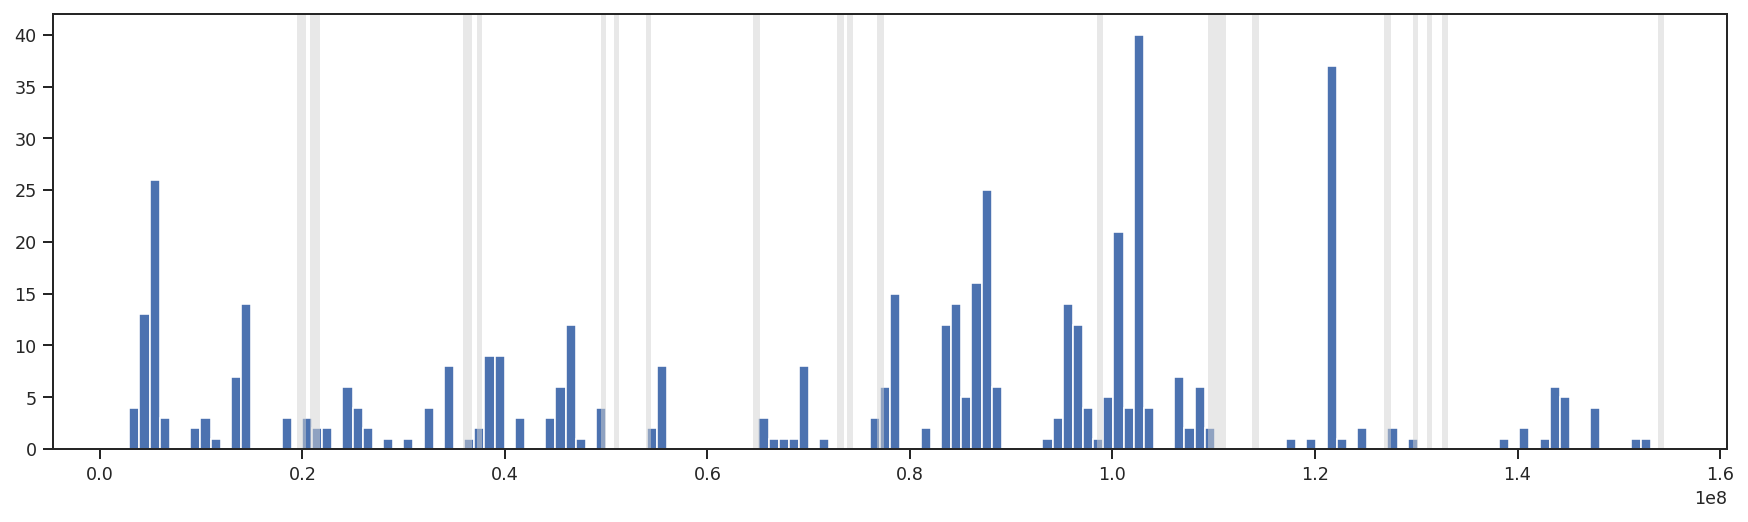

In [68]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    ax.hist(new_uncallable_when_admix_filtered.start, bins=150)

    for tup in extended_peak_regions_75.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 50, 
                 facecolor='lightgray', 
                 linewidth=0,
                 alpha=0.5,
                 zorder=1))

Distribution of such windows in each individual:

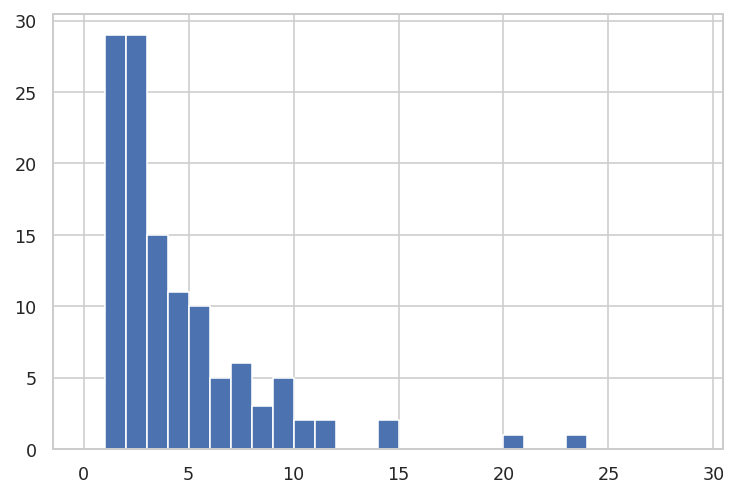

In [21]:
plt.hist(new_uncallable_when_admix_filtered.groupby('indiv_1').count().start, bins=range(30)) ;

#                                        (merged_data.swept == False) & (merged_data.swept_af == False) & \
#len(new_uncallable_when_admix_filtered)

To estimate the largest possible contribution of nan 100kb windows produced by masking we first find all the windows among those that can no longer be called after admix filtering, which overlap a sweep in another individual:

In [22]:
starts_of_ovl_ech_windows = list(set(new_uncallable_when_admix_filtered.start.unique())
         .intersection(set(merged_data.loc[merged_data.swept == True, 'start'].unique()) ))

uncallable_ovl_echs = new_uncallable_when_admix_filtered.loc[new_uncallable_when_admix_filtered.start.isin(starts_of_ovl_ech_windows)].sort_values('start')
uncallable_ovl_echs

indiv_1      start  swept  swept_af  mean_dist  \
195752           S_Papuan-8   20000000  False     False   0.000553   
195753           S_Papuan-8   20100000  False     False   0.000560   
195754           S_Papuan-8   20200000  False     False   0.000917   
124373        S_Jordanian-1   21300000  False     False   0.000146   
124374        S_Jordanian-1   21400000  False     False   0.000167   
234714            S_Uygur-2   36200000  False     False   0.000744   
87407   S_Eskimo_Sireniki-1   49500000  False     False   0.000574   
208463            S_Relli-1   49500000  False     False   0.000662   
8255                B_Han-3   49500000  False     False   0.000632   
9963      B_Ju_hoan_North-4   65100000  False     False   0.001695   
55088           S_Brahmin-1   76800000  False     False   0.001023   
55089           S_Brahmin-1   76900000  False     False   0.000924   
55090           S_Brahmin-1   77000000  False     False   0.000875   
55091           S_Brahmin-1   77100000  False     False   0.000354   
55092           S_Brahmin-1   77200000  False     False   0.000527   
55093           S_Brahmin-1   77300000  False     False   0.000546   
125148        S_Jordanian-1   98800000  False     False   0.000216   
146879          S_Kusunda-2   99100000  False     False   0.001374   
60069            S_Brahui-2  109300000  False     False   0.000745   
60070            S_Brahui-2  109400000  False     False   0.000465   
125433        S_Jordanian-1  127300000  False     False   0.000314   
46281            S_Basque-1  127300000   True     False   0.000309   
10613     B_Ju_hoan_North-4  130100000  False     False   0.000236   

        mean_dist_af  clade_size  clade_size_af  admix_prop  
195752           NaN         NaN            NaN         1.0  
195753           NaN         NaN            NaN         1.0  
195754           NaN         NaN            NaN         1.0  
124373           NaN         NaN            NaN         1.0  
124374           NaN         NaN            NaN         1.0  
234714           NaN         NaN            NaN         1.0  
87407            NaN         NaN            NaN         1.0  
208463           NaN         NaN            NaN         1.0  
8255             NaN         NaN            NaN         1.0  
9963             NaN         NaN            NaN         NaN  
55088            NaN         NaN            NaN         1.0  
55089            NaN         NaN            NaN         1.0  
55090            NaN         NaN            NaN         1.0  
55091            NaN         NaN            NaN         1.0  
55092            NaN         NaN            NaN         1.0  
55093            NaN         NaN            NaN         1.0  
125148           NaN         NaN            NaN         1.0  
146879           NaN         NaN            NaN         1.0  
60069            NaN         NaN            NaN         1.0  
60070            NaN         NaN            NaN         1.0  
125433           NaN         NaN            NaN         NaN  
46281            NaN        48.0            NaN         NaN  
10613            NaN         NaN            NaN         NaN

We can see that the windows in each individual are consequtive.

We can conservatively assume that all such windows were origianlly swept but *since then* where replaced by archaic introgression, and also that each set of consequtive windows in each individual has additional 4 windows on each side that cannot be called as swept.

Then we can compute how much such windows would contribute to the admixture proportions on ECHs.

In [23]:
nr_possibly_swept_windows_with_full_admixture = (uncallable_ovl_echs.groupby('indiv_1').start.count() + 4 + 4).sum()
nr_possibly_swept_windows_with_full_admixture

111

In [24]:
((merged_data.swept == True).sum() + nr_possibly_swept_windows_with_full_admixture) / (merged_data.swept == True).sum()

1.0080399826162538

So, the issue that admix masked windows cannot be called is should not incraese the admixture proportion by more than the above factor.

## Admixture segments across the X chromosome

In [27]:
extended_peak_regions_10 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pandas.read_hdf(analysis_globals.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')


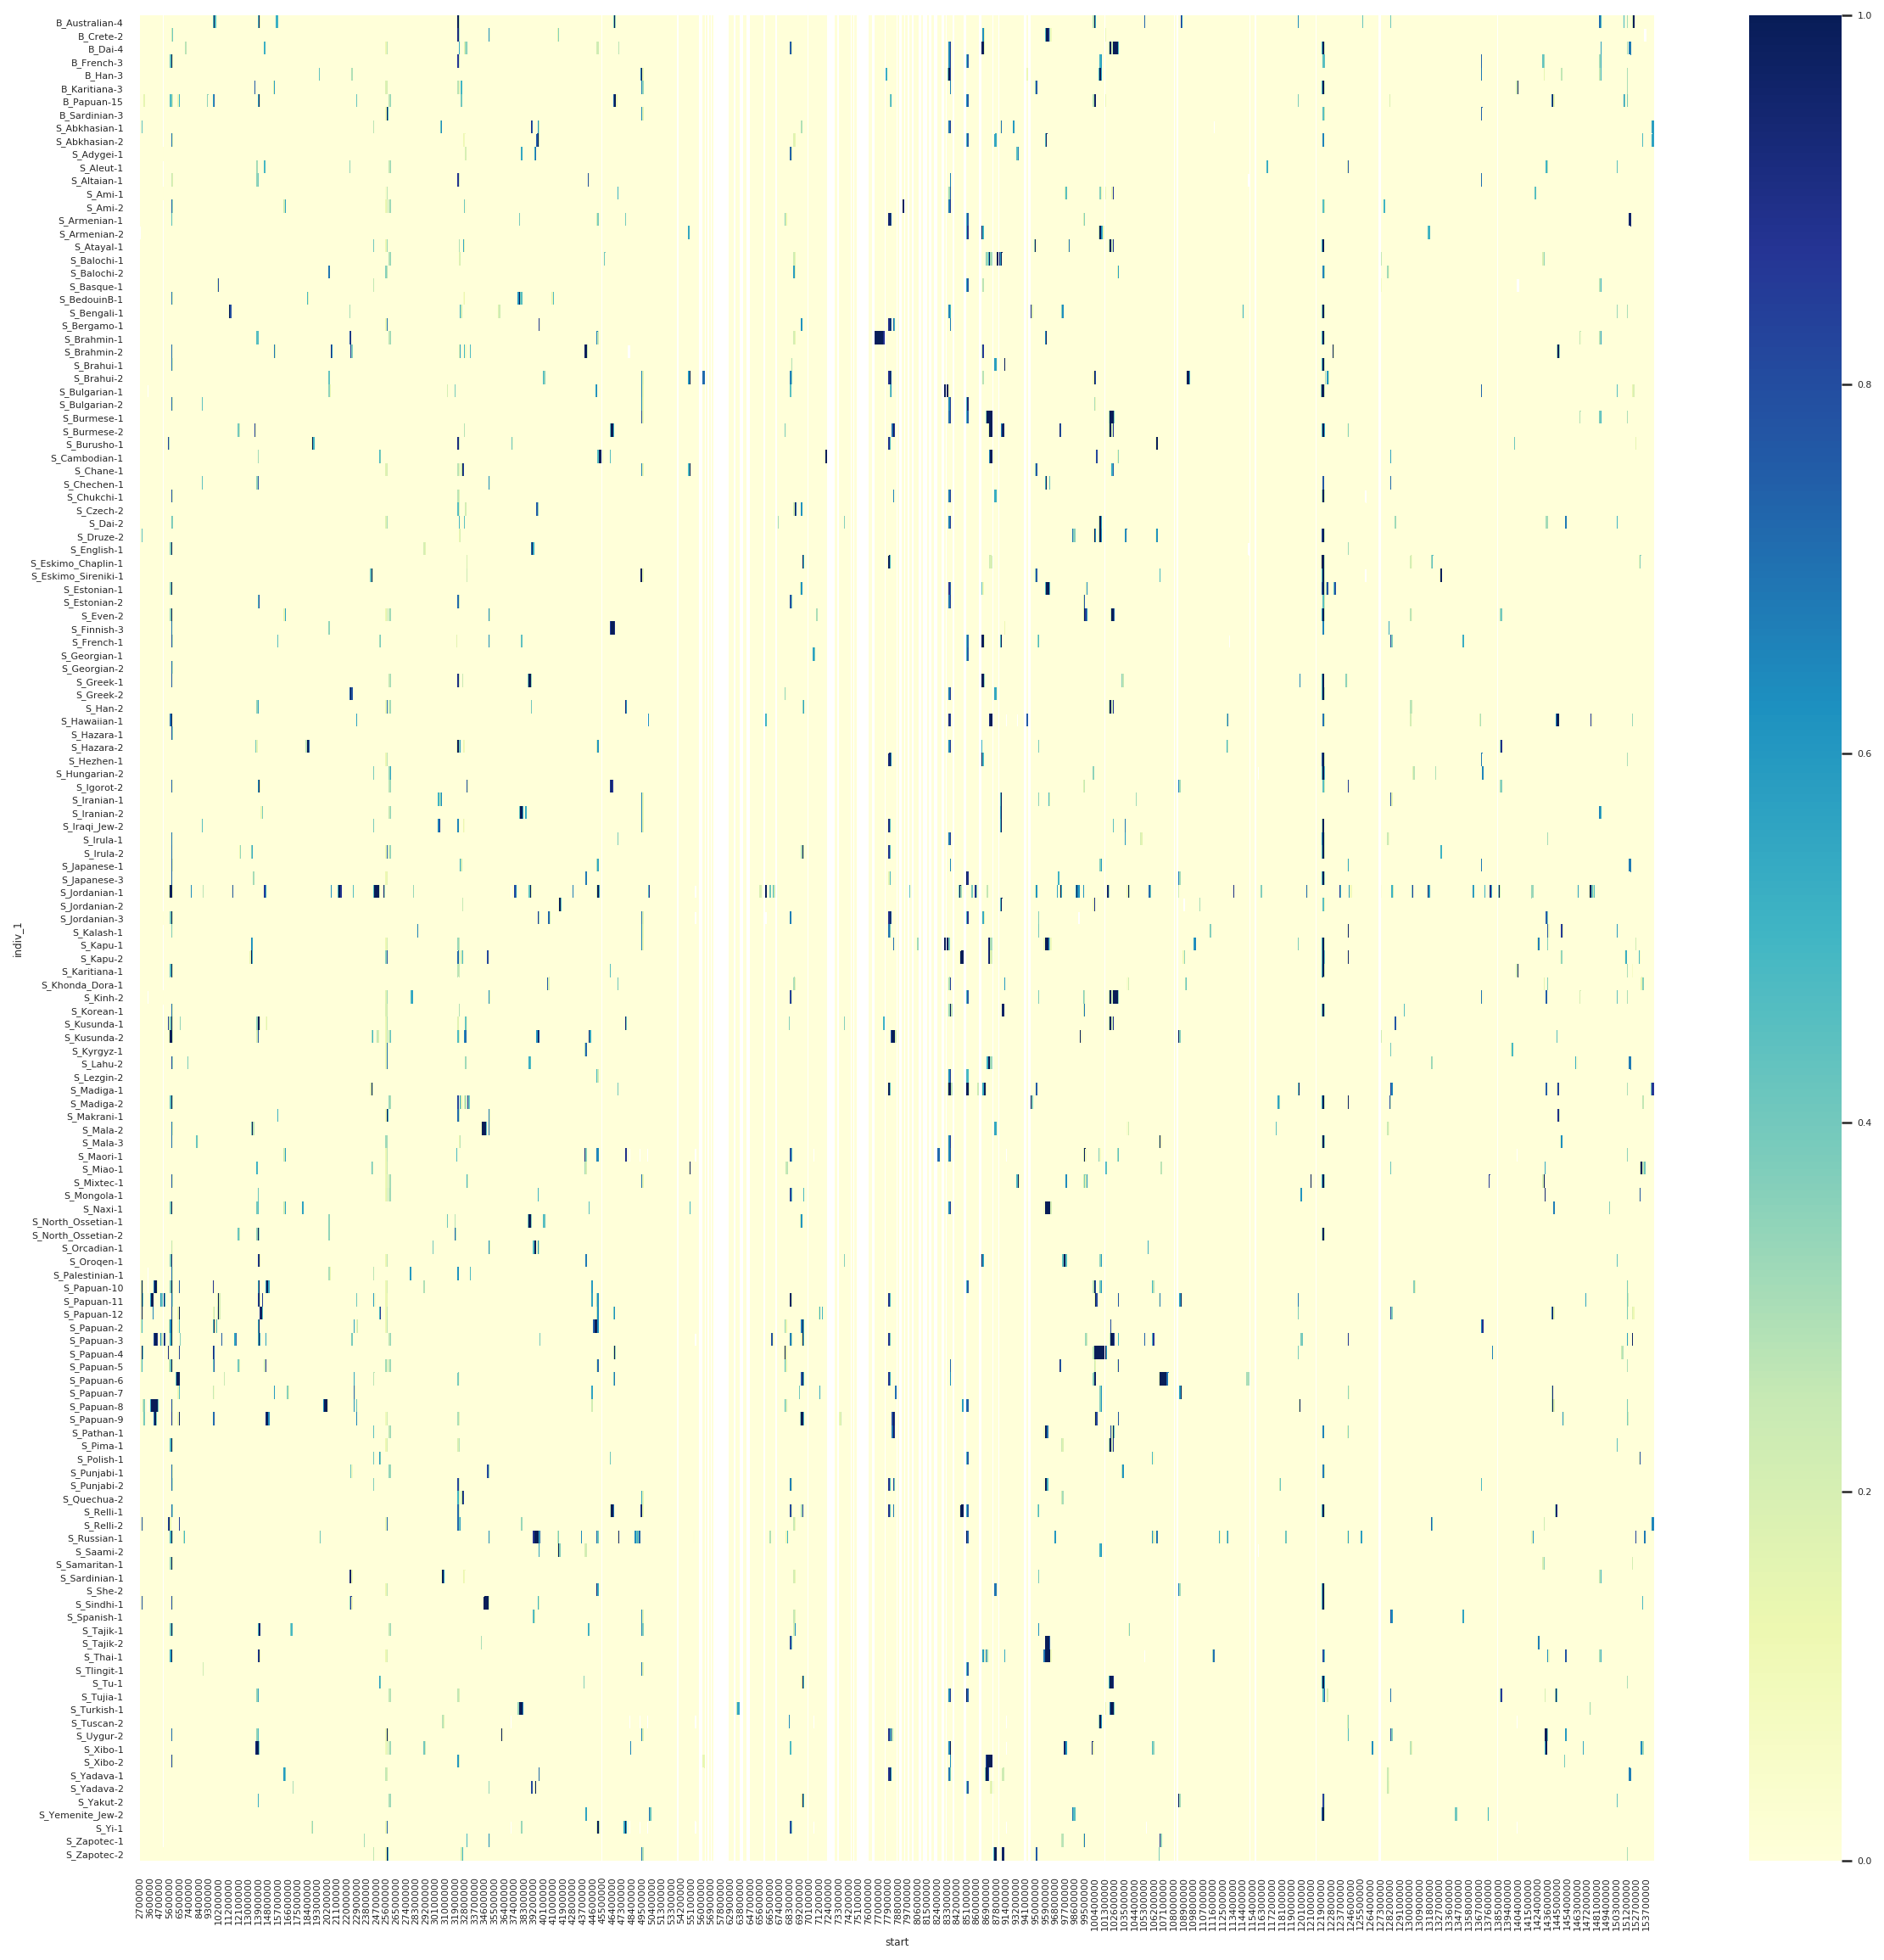

In [28]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(merged_data.loc[merged_data.region_1 != 'Africa'].pivot('indiv_1', 'start', 'admix_prop'), cmap="YlGnBu")

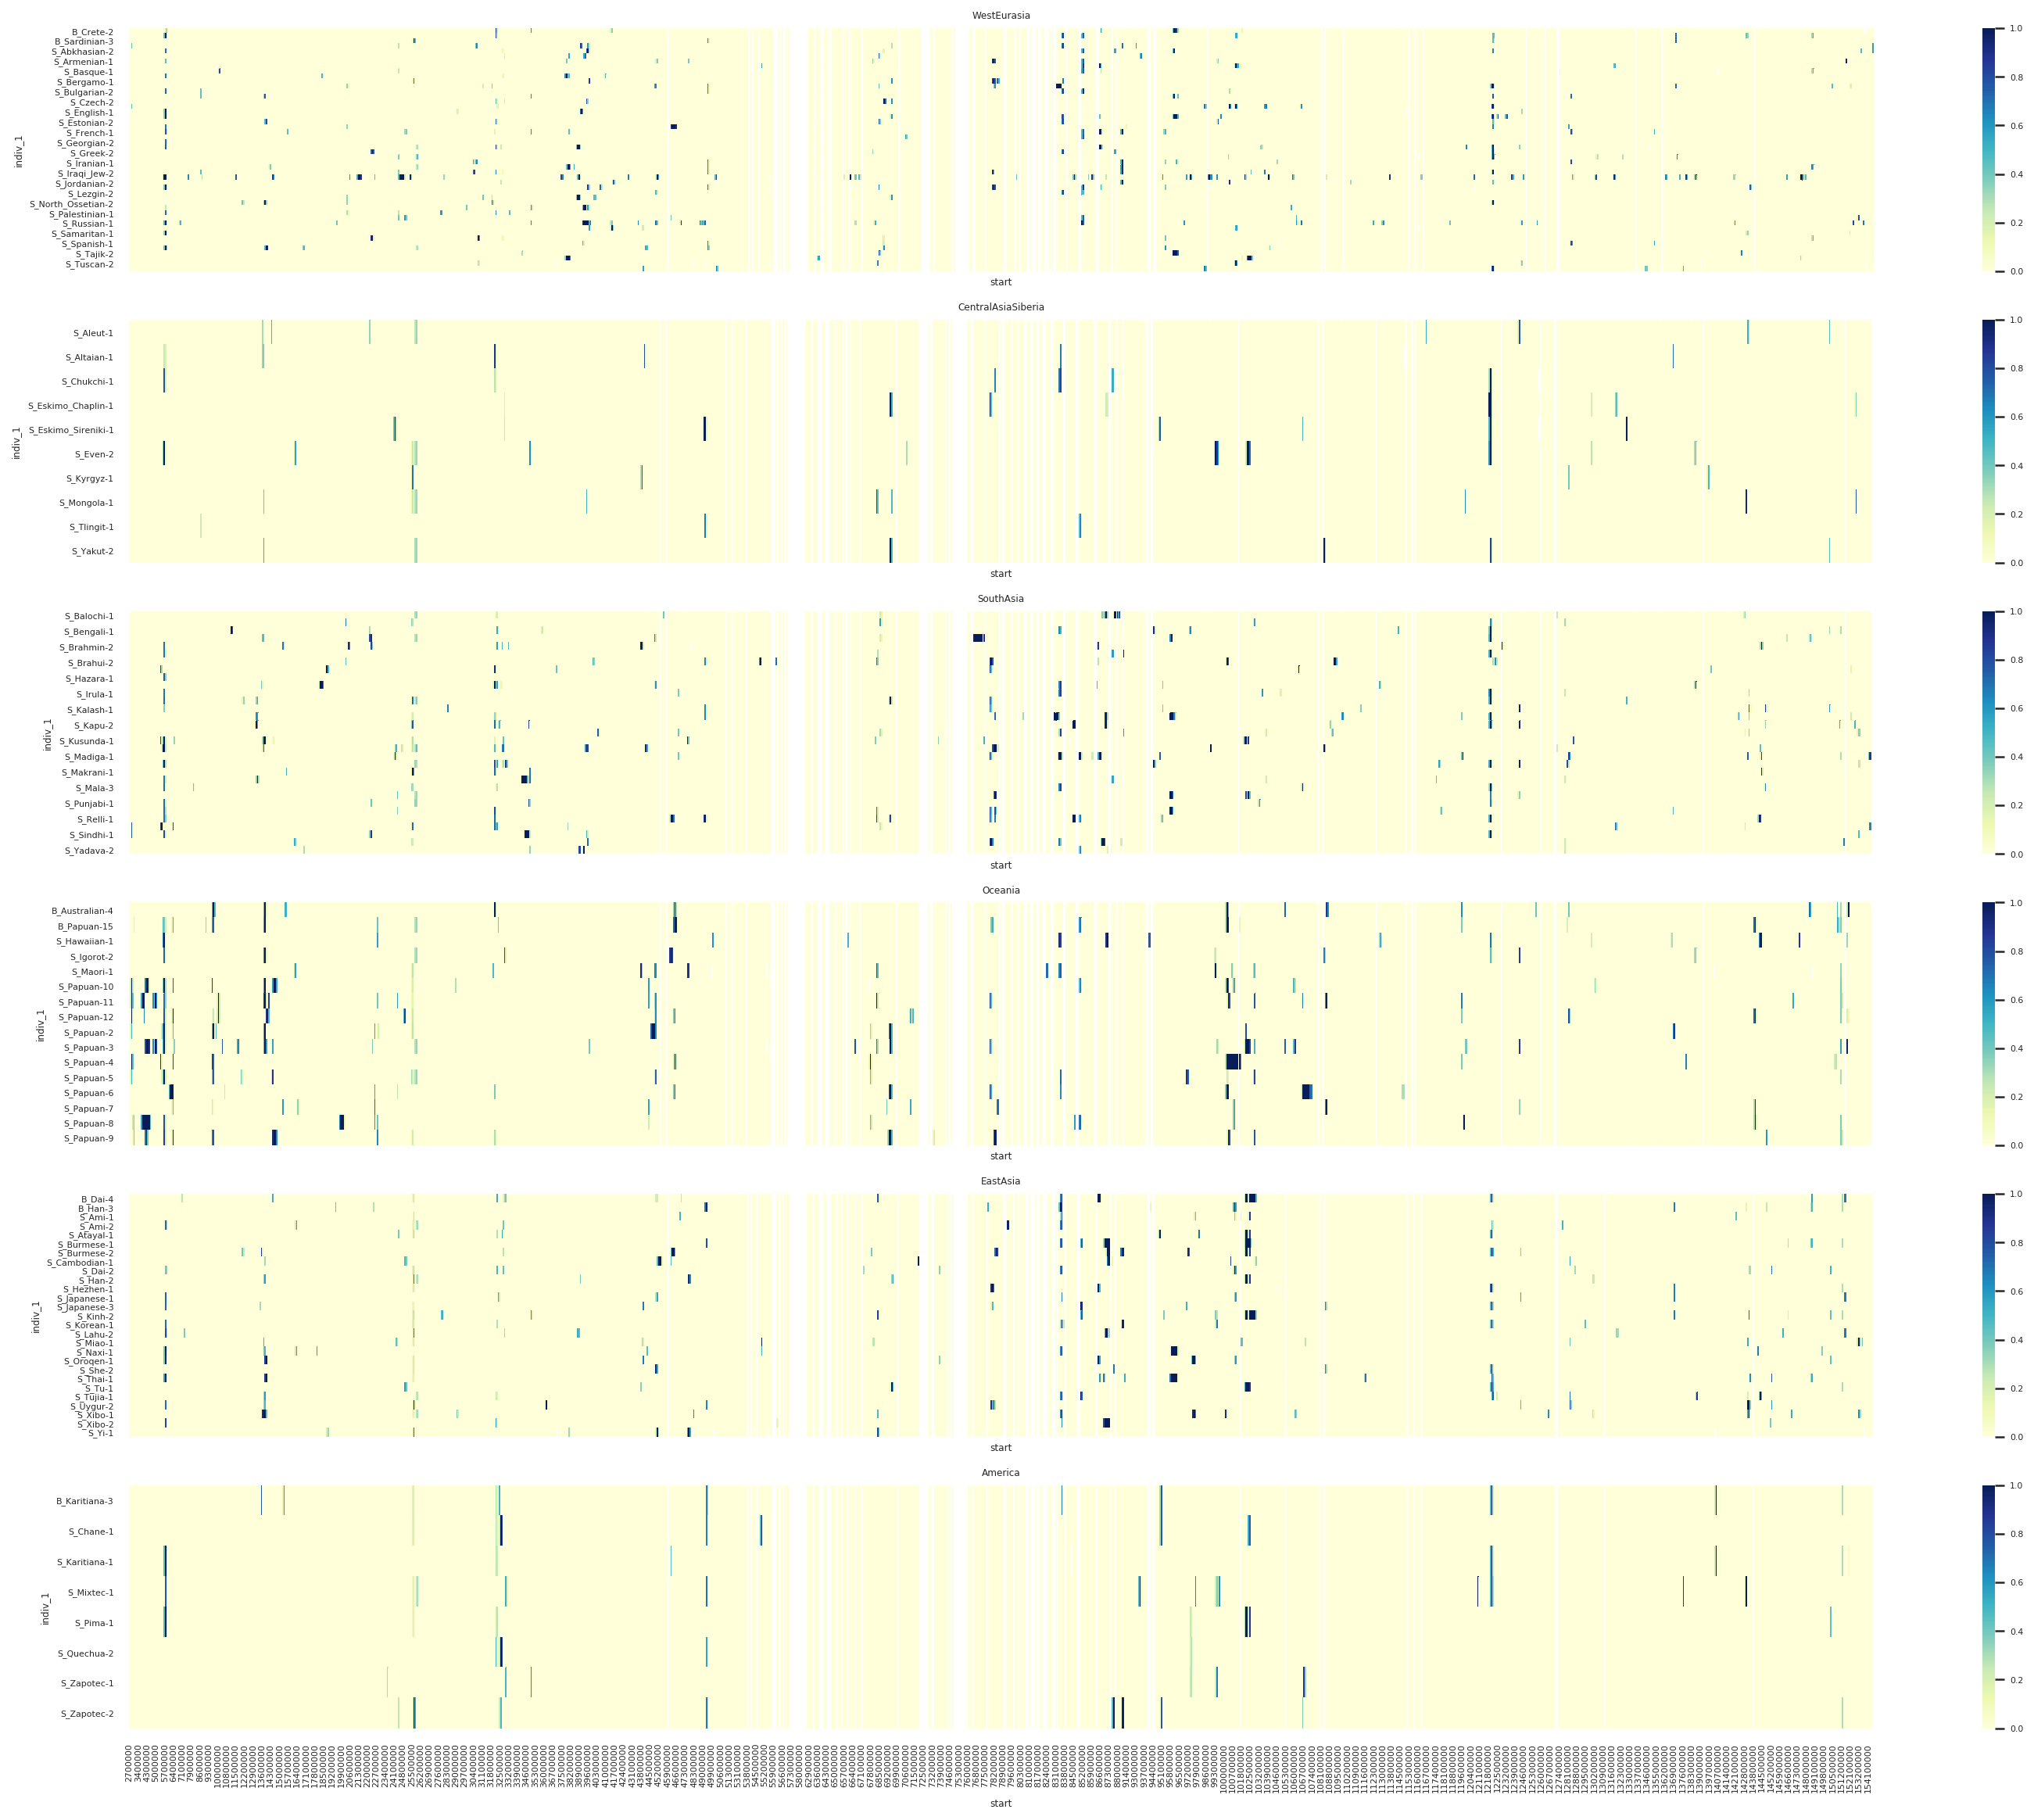

In [29]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(6, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
        df = merged_data.loc[merged_data.region_label_1 == region]
        table = df.pivot('indiv_1', 'start', 'admix_prop')
        ax = sns.heatmap(table, ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

## Admixture proportions in stratified by `never_swept`

In [31]:
merged_data.groupby('never_swept')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept                  
False        0.003000   21276
True         0.008776  148101

In [32]:
merged_data.groupby('never_swept_af')['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept_af                  
False           0.003000   21276
True            0.008776  148101

In [33]:
merged_data.groupby(['never_swept', 'never_swept_af'])['admix_prop'].agg(['mean', 'count'])

mean   count
never_swept never_swept_af                  
False       False           0.003000   21276
True        True            0.008776  148101

Test difference between `never_swept` `True` and `False`:

In [34]:
scipy.stats.ttest_ind(merged_data.loc[merged_data.never_swept == True, 'admix_prop'],
                      merged_data.loc[merged_data.never_swept == False, 'admix_prop'],
                      nan_policy='omit'
                     )

Ttest_indResult(statistic=10.536415159728792, pvalue=5.979026013234774e-26)

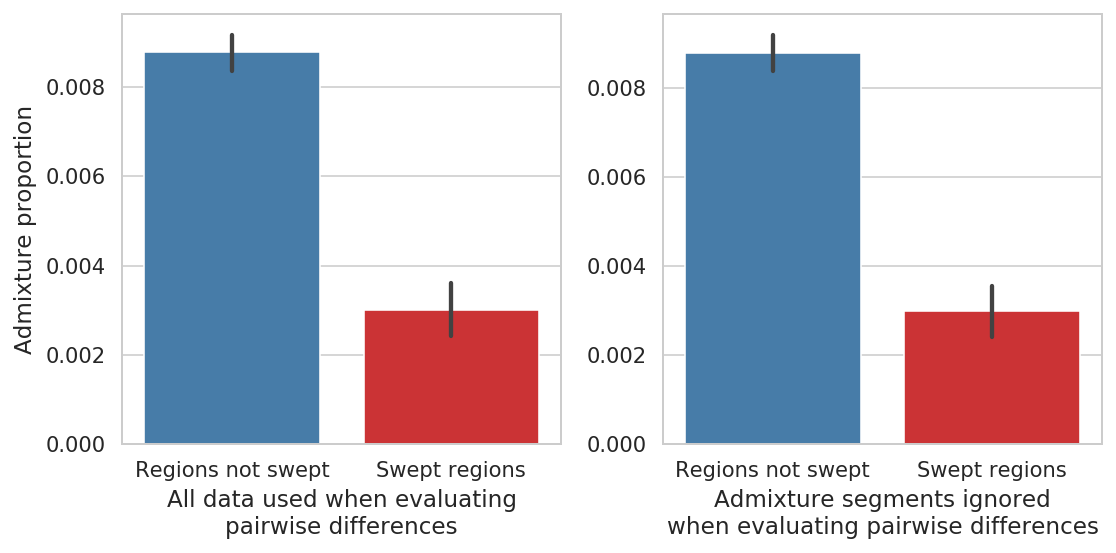

In [35]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            g1 = sns.barplot(x="not_never_swept", y="admix_prop", 
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), 
                             ax=ax1, n_boot=1000)
            g2 = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g1.set_ylabel("Admixture proportion")
            g2.set_ylabel("")
            g1.set_xlabel("All data used when evaluating\npairwise differences")
            g2.set_xlabel("Admixture segments ignored\nwhen evaluating pairwise differences")
            
            g1.set_xticklabels(['Regions not swept', 'Swept regions'])
            g2.set_xticklabels(['Regions not swept', 'Swept regions'])

            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.pdf'))
            plt.savefig(str(figures_dir / 'admix_in_swept_regions.png'))



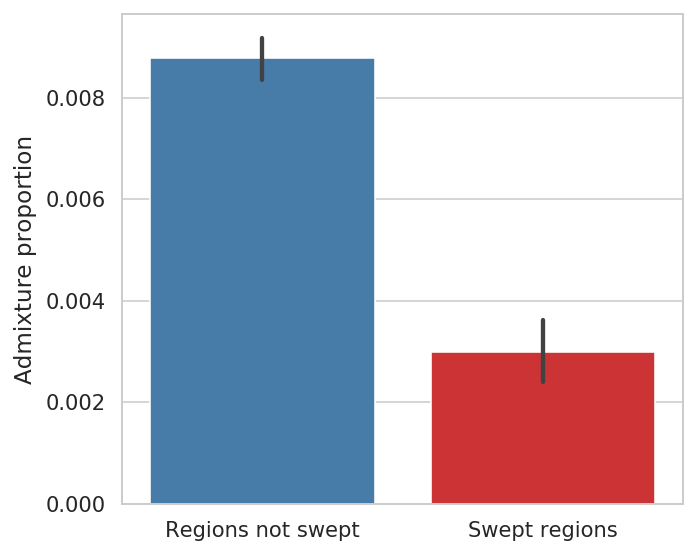

In [36]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, ax2 = plt.subplots(1, figsize=(5,4))
            g = sns.barplot(x="not_never_swept_af", y="admix_prop", 
                                data=merged_data.assign(not_never_swept_af=~merged_data.never_swept_af), 
                             ax=ax2)
            
            g.set_ylabel("Admixture proportion")
            g.set_xlabel('')
            g.set_xticklabels(['Regions not swept', 'Swept regions'])
                        
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'admix_in_swept_regions_af.pdf'))


## Admixture proportions only in windows that are `swept` in some males and not in others

In [37]:
df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept', 'admix_prop']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

df_af = (merged_data.loc[lambda df: (df.partial_sweep_win_af == True),# & (df.conserv_swept_group_af != 'ambig'),
                          ['indiv_1', 'region_1', 'start', 'swept_af', 'admix_prop']]
         
         
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
         
           .melt(id_vars=['indiv_1', 'region_1', 'start', 'admix_prop'], 
                 value_vars=['swept_af'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df = pandas.concat([df, df_af])
plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

plot_df.head()

indiv_1 region_1     start  admix_prop   call  is_swept
0  B_Australian-4  Oceania  19300000         0.0  swept     False
1  B_Australian-4  Oceania  19400000         0.0  swept     False
2  B_Australian-4  Oceania  19500000         0.0  swept      True
3  B_Australian-4  Oceania  19600000         0.0  swept      True
4  B_Australian-4  Oceania  19700000         0.0  swept      True

In [38]:
df = plot_df.groupby(['call', 'is_swept'])['admix_prop'].agg(['mean', 'sem'])
df

mean       sem
call     is_swept                    
swept    False     0.006971  0.000728
         True      0.000045  0.000028
swept_af False     0.006789  0.000723
         True      0.000191  0.000079

Reduction in admixture proportion in ECHs compared to ECHs in the same windows

In [39]:
(df.loc[('swept', False), 'mean'] - df.loc[('swept', True), 'mean']) / df.loc[('swept', False), 'mean']

0.9935328293162825

Plots are based on this many 100kb windows along the chromosome:

In [40]:
plot_df.start.drop_duplicates().size

173

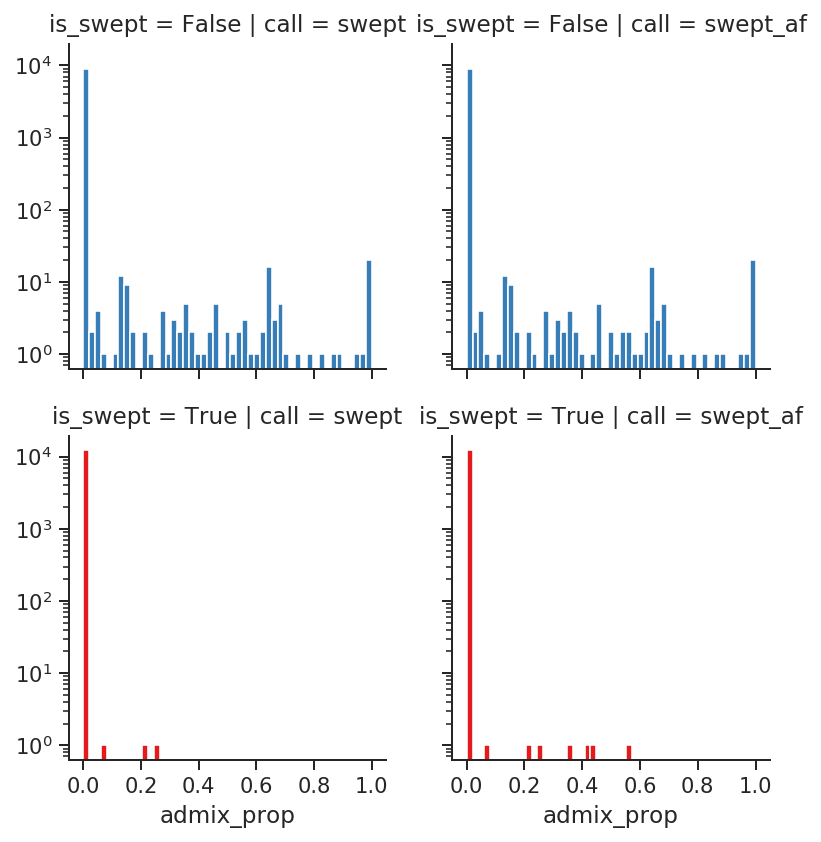

In [41]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.FacetGrid(row='is_swept', col='call', hue='is_swept', data=plot_df, sharex=True, sharey=True)
            g.map(plt.hist, 'admix_prop', bins=numpy.linspace(0, 1, 50))
            
#             g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
#             g.set_ylabel('Mean admixture proportion')
#             g.set_xlabel('')
#             g.set_xticklabels(['All data used when evaluating\npairwise differences', 
#                                'Admixture segments ignored\nwhen evaluating pairwise distances'])
            
            [ax.set_yscale('log') for ax in g.axes.flat]

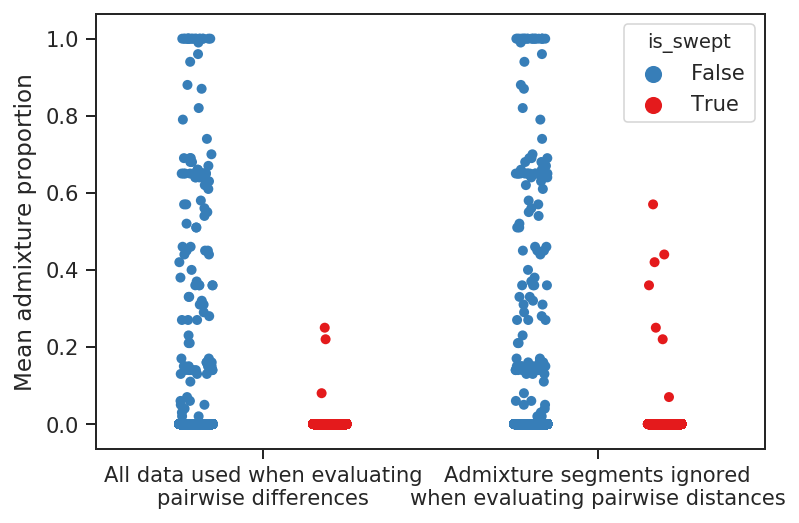

In [42]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.stripplot(x='call', y='admix_prop', hue='is_swept', jitter=True, dodge=True, data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
#            g.set_yscale('log')

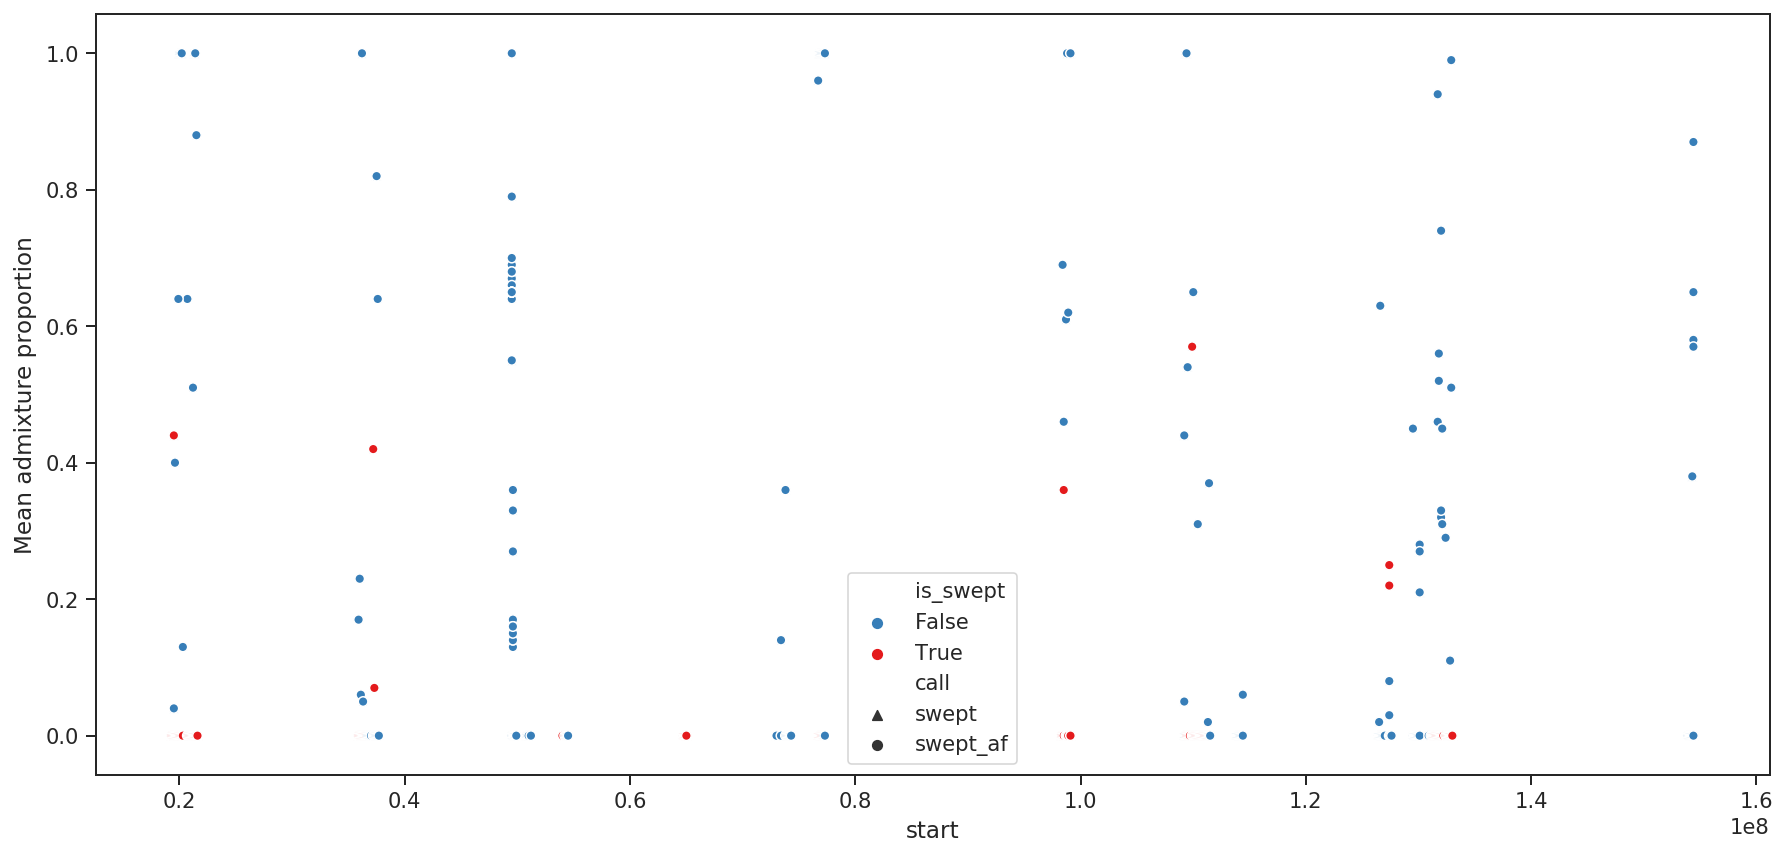

In [43]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            plt.figure(figsize=(15,7))
            g = sns.scatterplot(x='start', y='admix_prop', style='call', hue='is_swept', markers=['^', 'o'], data=plot_df)
            g.set_ylabel('Mean admixture proportion')

In [44]:
#pandas.pivot_table(plot_df, index=['start', 'admix_prop'], columns='is_swept')

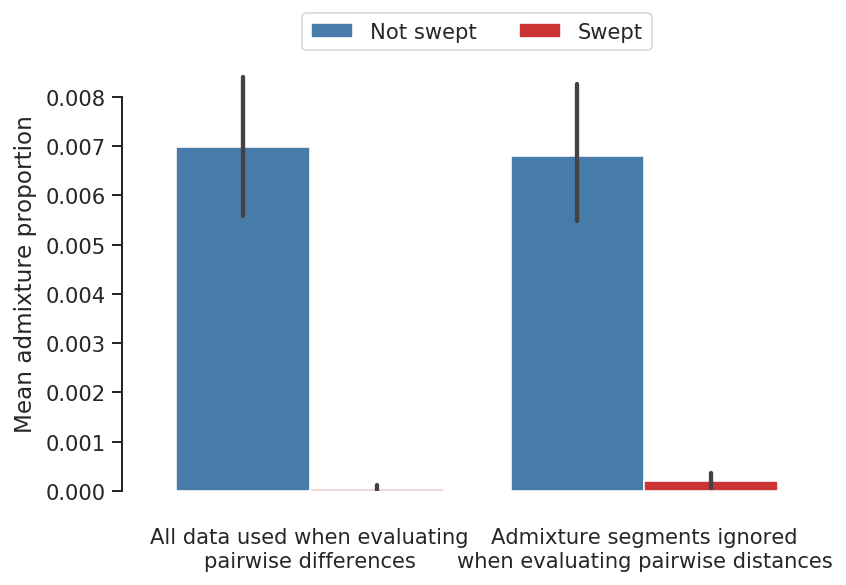

In [45]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='call', y='admix_prop', hue='is_swept', data=plot_df)
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['All data used when evaluating\npairwise differences', 
                               'Admixture segments ignored\nwhen evaluating pairwise distances'])
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()

            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',
                     ncol=2
                    )
            
            sns.despine(trim=True, offset=10)

            plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            ) # labels along the bottom edge are off
            plt.gca().axes.spines['bottom'].set_visible(False)
                
            plt.savefig(str(figures_dir / 'admix_prop_by_call.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call.png'))

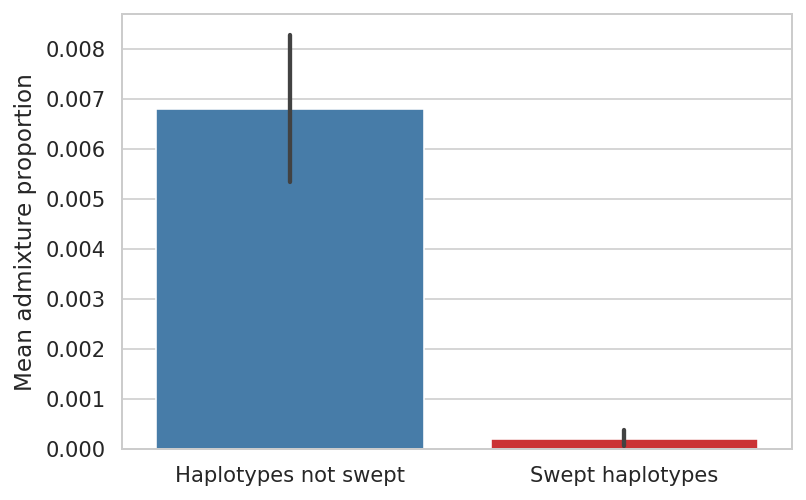

In [46]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.2):
            g = sns.barplot(x='is_swept', y='admix_prop', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af']
                           )
            g.set_ylabel('Mean admixture proportion')
            g.set_xlabel('')
            g.set_xticklabels(['Haplotypes not swept', 'Swept haplotypes'])

            plt.savefig(str(figures_dir / 'admix_prop_af.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_af.png'))

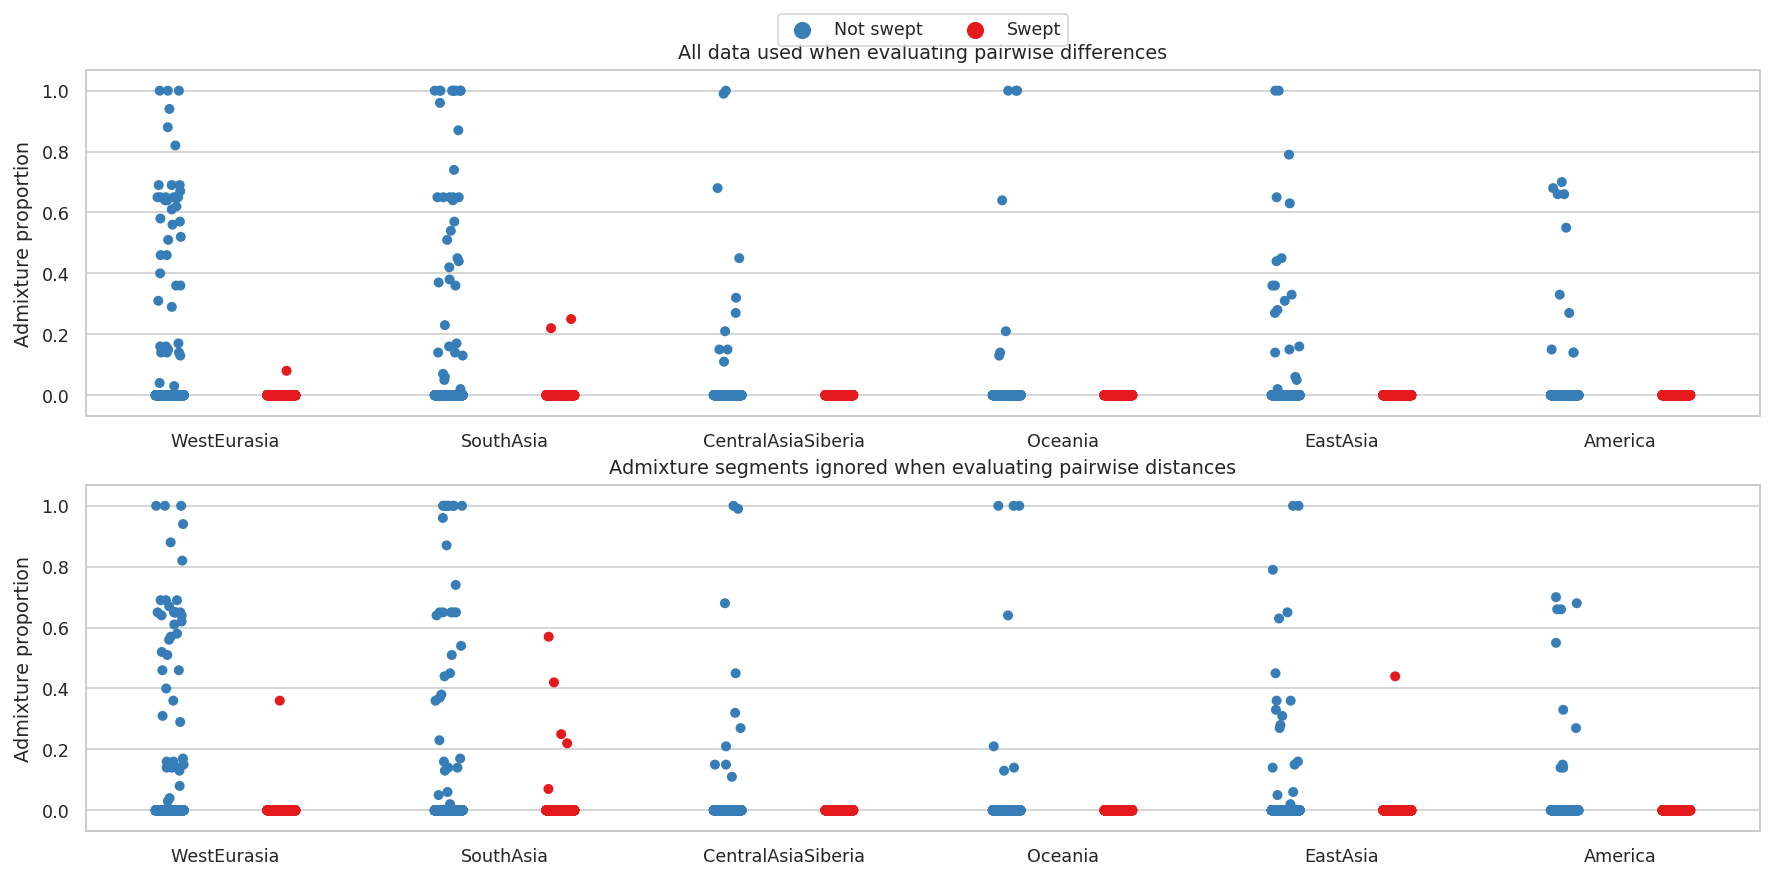

In [47]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=True)

            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.stripplot(x='region_1', y='admix_prop', hue='is_swept', jitter=True, dodge=True,
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

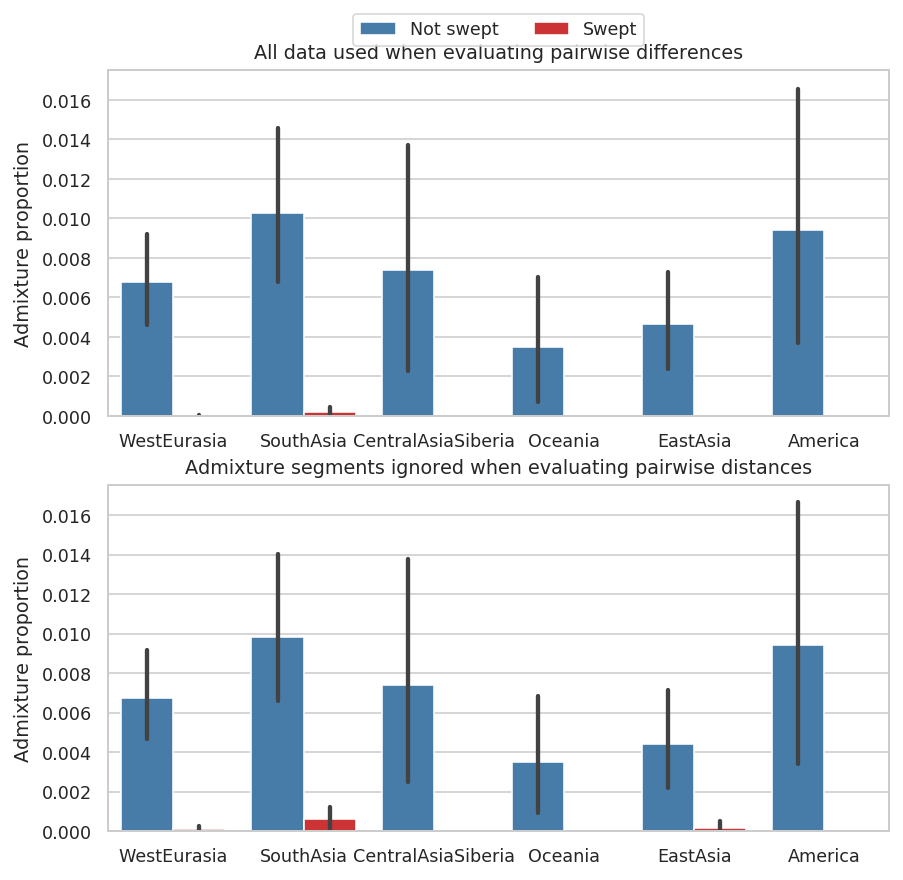

In [48]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharey=True)

            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax1)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )
            ax1.set_title('All data used when evaluating pairwise differences')
            
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept_af'], ax=ax2)
            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')

            ax2.legend().set_visible(False)
            ax2.set_title('Admixture segments ignored when evaluating pairwise distances')

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.pdf'))
            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region.png'))

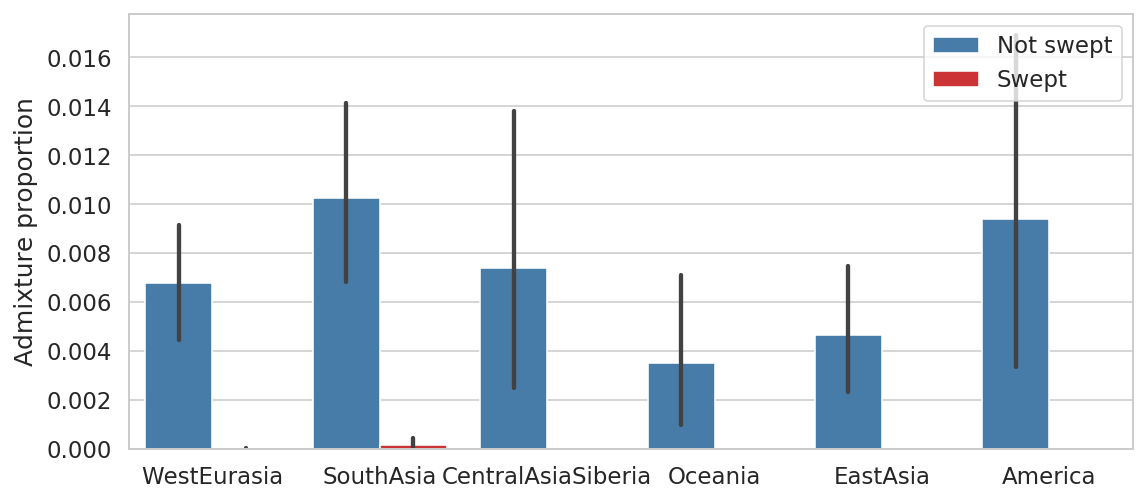

In [49]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.3):
            
            fig, ax = plt.subplots(1, 1, figsize=(9, 4))
                
            g = sns.barplot(x='region_1', y='admix_prop', hue='is_swept', 
                            data=plot_df.loc[lambda df: df.call == 'swept'], ax=ax)

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 'Swept'],
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=2
                    )

            g.legend(handles, ['Not swept', 
                               'Swept',
                              ],
                     loc='upper right',
                     ncol=1
                    )
            plt.savefig(str(figures_dir / 'admix_prop_by_region.pdf'))


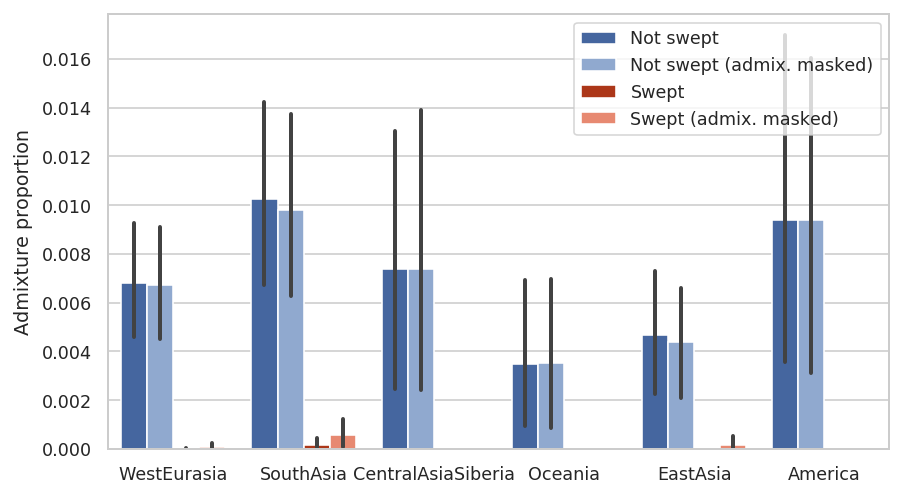

In [50]:
with sns.color_palette(["#3662AE", "#86A7D9", "#C52900", "#FB7D5D"]):
    with sns.axes_style('whitegrid'):
        with sns.plotting_context('paper', font_scale=1.0):
            
            fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))

            g = sns.barplot(x='region_1', y='admix_prop', hue='label', 
                            data=plot_df.assign(label=plot_df.call.astype(str) + "_" + plot_df.is_swept.astype(str)), 
                            hue_order=['swept_False', 'swept_af_False', 'swept_True', 'swept_af_True'],
                            ax=ax1,
                            errwidth=2,
                            #width = .8
                           )

            g.set_ylabel('Admixture proportion')
            g.set_xlabel('')
            g.get_legend().set_title('Is swept')
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles, ['Not swept', 
                               'Not swept (admix. masked)',
                               'Swept',
                               'Swept (admix. masked)',
                              ],
                     #bbox_to_anchor=(1., 1.0),  loc='upper left',
                     loc='upper right',
#                     bbox_to_anchor=(0., 1.08, 1., .108), loc='upper center',
                     ncol=1
                    )

            plt.savefig(str(figures_dir / 'admix_prop_by_call_and_region_version2.pdf'))

Admixture proportions:

In [51]:
(plot_df
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
)

mean       sem
call     region_1           is_swept                    
swept    WestEurasia        False     0.006803  0.001183
                            True      0.000019  0.000019
         SouthAsia          False     0.010265  0.001928
                            True      0.000181  0.000128
         CentralAsiaSiberia False     0.007389  0.002903
                            True      0.000000  0.000000
         Oceania            False     0.003503  0.001586
                            True      0.000000  0.000000
         EastAsia           False     0.004659  0.001326
                            True      0.000000  0.000000
         America            False     0.009407  0.003358
                            True      0.000000  0.000000
swept_af WestEurasia        False     0.006716  0.001178
                            True      0.000087  0.000087
         SouthAsia          False     0.009824  0.001911
                            True      0.000585  0.000300
         CentralAsiaSiberia False     0.007389  0.002903
                            True      0.000000  0.000000
         Oceania            False     0.003509  0.001589
                            True      0.000000  0.000000
         EastAsia           False     0.004389  0.001300
                            True      0.000176  0.000176
         America            False     0.009407  0.003358
                            True      0.000000  0.000000

In the admixture filtered analysis, confidence intervals for mean admixture proportions overlap, or nearly overlap zero. Add to that that Laurit's method has a false positive rate of 5-10%.

In [52]:
(plot_df.loc[lambda df: (df.call=='swept_af') & (df.is_swept==True)]
 .groupby(['call', 'region_1', 'is_swept'])['admix_prop']
 .agg(['mean', 'sem'])
 .reset_index()
 .assign(non_zero=lambda df: df['mean']-1.96*df['sem'])
)

call            region_1  is_swept      mean       sem  non_zero
0  swept_af         WestEurasia      True  0.000087  0.000087 -0.000083
1  swept_af           SouthAsia      True  0.000585  0.000300 -0.000003
2  swept_af  CentralAsiaSiberia      True  0.000000  0.000000  0.000000
3  swept_af             Oceania      True  0.000000  0.000000  0.000000
4  swept_af            EastAsia      True  0.000176  0.000176 -0.000169
5  swept_af             America      True  0.000000  0.000000  0.000000

### Chromosome wide admixture proportion excluding the swept haplotypes we call:

Compute mean admixture of each 100kb window when sweept windows are excluded and then compute chromosome mean:

In [53]:
chrom_admix_without_sweeps = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix_without_sweeps

mean       sem     upper     lower
admix_prop  0.007687  0.001821  0.011255  0.004118

In [54]:
chrom_admix = (plot_df
 .groupby(['start'])
 .agg('mean')
 .reset_index()
 .agg(['mean', 'sem'])
 .transpose()
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
 .loc[['admix_prop']]                              
)
chrom_admix

mean       sem     upper     lower
admix_prop  0.003  0.000812  0.004591  0.001408

In [55]:
(chrom_admix_without_sweeps['mean'] - chrom_admix['mean']) / chrom_admix_without_sweeps['mean']

admix_prop    0.609748
Name: mean, dtype: float64

Same but by region:

In [56]:
chrom_admix_without_sweeps_by_region = (plot_df
 .loc[lambda df: (df.call=='swept_af') & (df.is_swept==False)]
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_without_sweeps_by_region

mean       sem     upper     lower
region_1                                                  
WestEurasia         0.007087  0.002005  0.011017  0.003157
SouthAsia           0.011529  0.002658  0.016739  0.006320
CentralAsiaSiberia  0.007191  0.003565  0.014178  0.000204
Oceania             0.003744  0.001624  0.006927  0.000562
EastAsia            0.004795  0.002404  0.009507  0.000083
America             0.006313  0.005016  0.016143 -0.003518

Same computation but inlcuding all windows for al individuals:

In [57]:
chrom_admix_by_region = (plot_df
 .groupby(['region_1', 'start'])
 .agg('mean')
 .reset_index()
 .groupby('region_1')['admix_prop']
 .agg(['mean', 'sem'])
 .assign(upper=lambda df: df['mean'] + 1.96*df['sem'],
         lower=lambda df: df['mean'] - 1.96*df['sem'])
)
chrom_admix_by_region

mean       sem     upper     lower
region_1                                                  
WestEurasia         0.002950  0.000947  0.004806  0.001094
SouthAsia           0.004699  0.000990  0.006640  0.002758
CentralAsiaSiberia  0.002849  0.001371  0.005537  0.000161
Oceania             0.001694  0.000758  0.003180  0.000208
EastAsia            0.001815  0.000718  0.003222  0.000409
America             0.003520  0.002798  0.009005 -0.001965

How much higher would the chromosome average admixture level be if we take out swept haplotypes:

In [58]:
(chrom_admix_without_sweeps_by_region['mean'] - chrom_admix_by_region['mean']) / chrom_admix_without_sweeps_by_region['mean']

region_1
WestEurasia           0.583735
SouthAsia             0.592452
CentralAsiaSiberia    0.603844
Oceania               0.547552
EastAsia              0.621396
America               0.442434
Name: mean, dtype: float64

### Plot below is not for use but only for keeping as template in case I do a more thorough analysis on Laurits larger Papuan set.

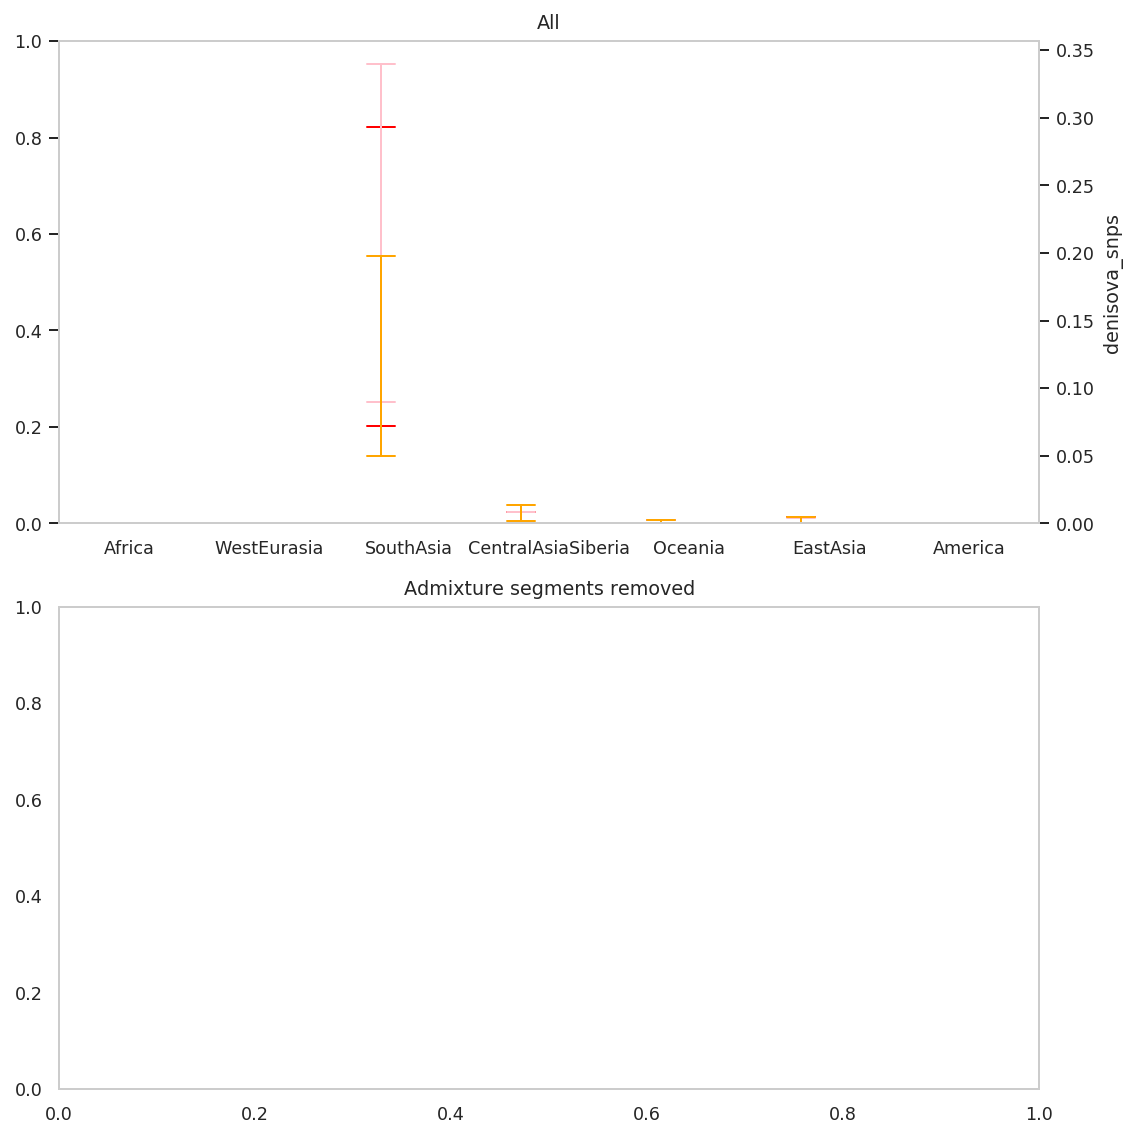

In [59]:
sweep_and_admix_data_subset = (merged_data
                               .groupby(['start'])
                               .filter(lambda df: df.swept.sum() > 0)
                              )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept', 
#                             data=merged_data.loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')], 
#                             ax=ax1, n_boot=1000)
            ax1.grid(False)
            ax1.set_title("All")

            extra_ax = ax1.twinx()
            sns.barplot(x='region_1', y='altai_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="red")
            sns.barplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="pink")
            sns.barplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=extra_ax,
                         facecolor=(1, 0, 0, 0), errwidth=1, capsize=0.2, errcolor="orange")
            extra_ax.grid(False)
            extra_ax.legend_.remove()

            for item in g.get_xticklabels():
                item.set_rotation(25)

#             g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
#                 data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
#                             ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Admixture segments removed")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

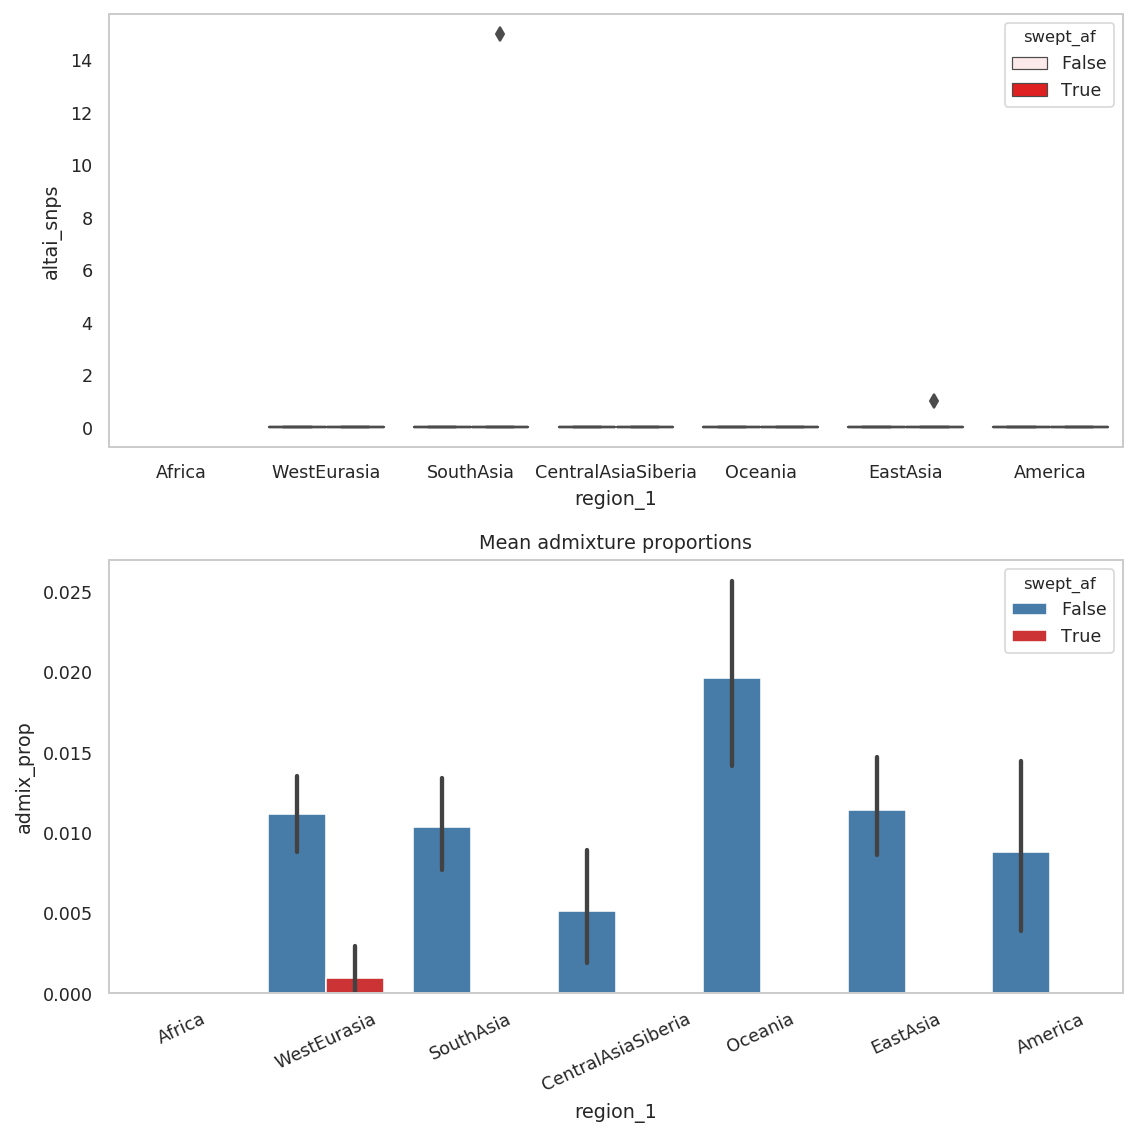

In [66]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

            ax1.grid(False)
            sns.boxplot(x='region_1', y='altai_snps', hue='swept_af', data=sweep_and_admix_data_subset, ax=ax1,
                         color="red")
#             sns.boxplot(x='region_1', y='vindija_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="pink")
#             sns.boxplot(x='region_1', y='denisova_snps', hue='swept', data=sweep_and_admix_data_subset, ax=ax1,
#                          color="orange")

            for item in g.get_xticklabels():
                item.set_rotation(25)

            g = sns.barplot(x="region_1", y="admix_prop", hue='swept_af', 
                data=merged_data.loc[lambda df: (df.never_win_swept_af == False) & (df.conserv_swept_group_af != 'ambig')], 
                            ax=ax2, n_boot=1000)
            ax2.grid(False)
            ax2.set_title("Mean admixture proportions")


            for item in g.get_xticklabels():
                item.set_rotation(25)
                
            plt.tight_layout()
            
#            plt.savefig(str(figures_dir / 'admix_and_sweeps_by_region.png'))

## Which swept windows have admixture when calling with admix filter?

In [67]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_data.loc[lambda df: (df.never_win_swept_af == False) & \
#                            (df.conserv_swept_group_af != 'ambig') &  \
                            (df.admix_prop > 0)]
            .sort_values(by=['admix_prop'], ascending=False))

indiv_1      start        end            pop_1  \
138186        S_Karitiana-1    5800000    5900000        Karitiana   
173235             S_Naxi-1   96300000   96400000             Naxi   
181642          S_Papuan-10    5800000    5900000           Papuan   
183187          S_Papuan-11    5100000    5200000           Papuan   
183238          S_Papuan-11   10200000   10300000           Papuan   
92563              S_Even-2   99500000   99600000             Even   
91626              S_Even-2    5800000    5900000             Even   
184790          S_Papuan-12   10200000   10300000           Papuan   
89426          S_Estonian-1   96200000   96300000         Estonian   
89425          S_Estonian-1   96100000   96200000         Estonian   
186298           S_Papuan-2    5800000    5900000           Papuan   
186689           S_Papuan-2   44900000   45000000           Papuan   
88522          S_Estonian-1    5800000    5900000         Estonian   
187843           S_Papuan-3    5100000    5200000           Papuan   
187850           S_Papuan-3    5800000    5900000           Papuan   
82314           S_English-1    5800000    5900000          English   
190954           S_Papuan-5    5800000    5900000           Papuan   
192511           S_Papuan-6    6300000    6400000           Papuan   
193517           S_Papuan-6  106900000  107000000           Papuan   
70166             S_Chane-1   32600000   32700000            Chane   
193518           S_Papuan-6  107000000  107100000           Papuan   
193521           S_Papuan-6  107300000  107400000           Papuan   
66925           S_Burusho-1   18900000   19000000          Burusho   
195595           S_Papuan-8    4300000    4400000           Papuan   
195752           S_Papuan-8   20000000   20100000           Papuan   
61362         S_Bulgarian-1   83400000   83500000        Bulgarian   
60070            S_Brahui-2  109400000  109500000           Brahui   
181627          S_Papuan-10    4300000    4400000           Papuan   
173234             S_Naxi-1   96200000   96300000             Naxi   
199615           S_Pathan-1   95900000   96000000           Pathan   
173233             S_Naxi-1   96100000   96200000             Naxi   
125546        S_Jordanian-1  138600000  138700000        Jordanian   
124409        S_Jordanian-1   24900000   25000000        Jordanian   
124408        S_Jordanian-1   24800000   24900000        Jordanian   
124407        S_Jordanian-1   24700000   24800000        Jordanian   
125635        S_Jordanian-1  147500000  147600000        Jordanian   
124374        S_Jordanian-1   21400000   21500000        Jordanian   
125636        S_Jordanian-1  147600000  147700000        Jordanian   
127322        S_Jordanian-3    5800000    5900000        Jordanian   
124218        S_Jordanian-1    5800000    5900000        Jordanian   
123459         S_Japanese-3   85100000   85200000         Japanese   
135858             S_Kapu-1   83400000   83500000             Kapu   
135983             S_Kapu-1   95900000   96000000             Kapu   
135985             S_Kapu-1   96100000   96200000             Kapu   
136709             S_Kapu-2   13300000   13400000             Kapu   
142261             S_Kinh-2  102900000  103000000             Kinh   
144394          S_Kusunda-1    5800000    5900000          Kusunda   
145946          S_Kusunda-2    5800000    5900000          Kusunda   
152947           S_Madiga-1   85100000   85200000           Madiga   
153706           S_Madiga-2    5800000    5900000           Madiga   
157098             S_Mala-2   34600000   34700000             Mala   
162403            S_Maori-1   99500000   99600000            Maori   
169148             S_Miao-1  153200000  153300000             Miao   
172330             S_Naxi-1    5800000    5900000             Naxi   
173231             S_Naxi-1   95900000   96000000             Naxi   
104042         S_Hawaiian-1    5800000    5900000         Hawaiian   
197147           S_Papuan-9   

## Correlation between proportion of windows swept and admixture proportion in each individual

There is a relation between amount swept and admixtue, as would be expected if sweeps displace admixture.

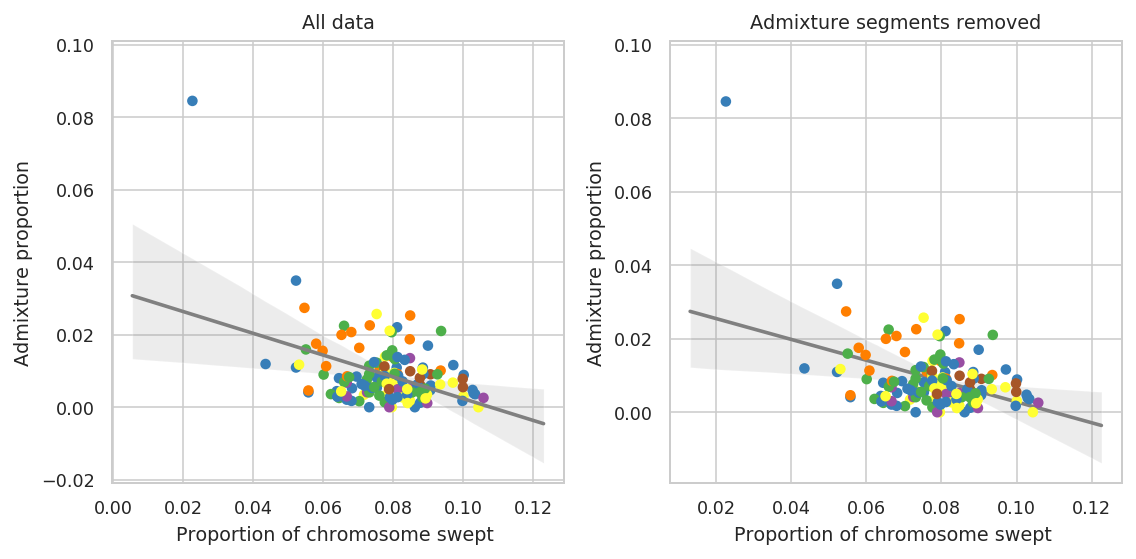

In [68]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
#           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept.pdf'))


The same but with the following two outliers removed:

In [69]:
print(plot_df.loc[plot_df.admix_prop > 0.03])

           indiv_1     region_1     swept  swept_af  admix_prop
561  S_Jordanian-1  WestEurasia  0.022595  0.029883    0.084539
953    S_Russian-1  WestEurasia  0.052212  0.052212    0.034945


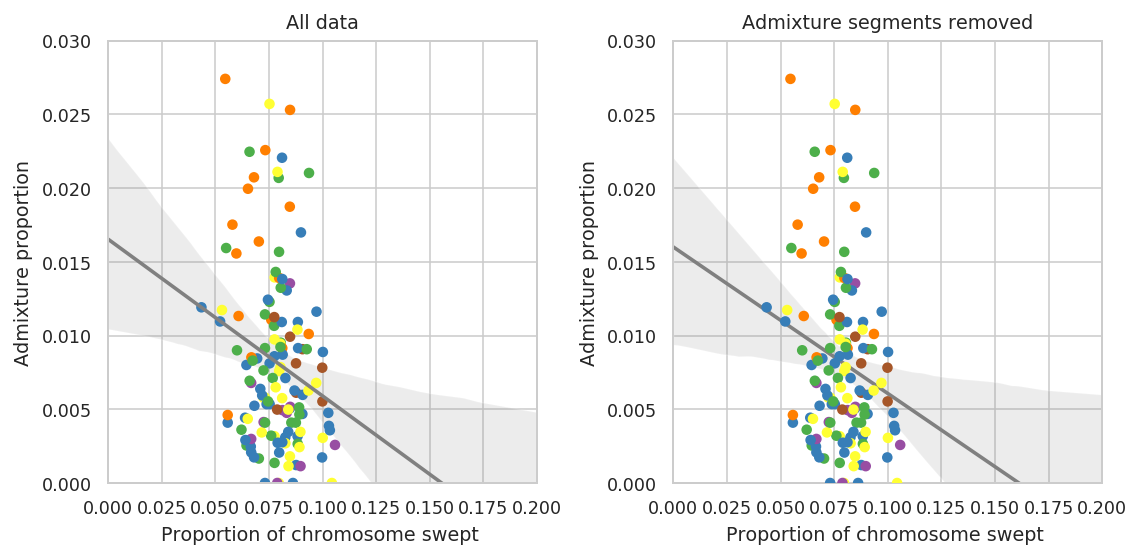

In [70]:
plot_df = (merged_data[['indiv_1', 'region_1', 'swept', 'swept_af', 'admix_prop']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: df.admix_prop < 0.03]
           .loc[lambda df: (~numpy.isnan(df.swept)) & (df.region_1 != 'Africa')]
          )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = [region_colors[x] for x in plot_df.region_1]

ax1.set_ylim(0, 0.03)
ax1.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.03)
ax2.set_xlim(0, 0.2)

g = sns.regplot(data=plot_df, x='swept', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax1)
g = ax1.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors,
                     label=colors)
ax1.set_title('All data')
ax1.set_ylabel('Admixture proportion')
ax1.set_xlabel('Proportion of chromosome swept ')


g = sns.regplot(data=plot_df, x='swept_af', y='admix_prop', color='grey', 
                #scatter=False, 
                scatter_kws={'alpha': 0},
                ax=ax2)
g = ax2.scatter(plot_df.swept, plot_df.admix_prop,
                     s=20, #edgecolors='none',
                     c=colors, zorder=3,
                     label=colors)
ax2.set_title('Admixture segments removed')
ax2.set_ylabel('Admixture proportion')
ax2.set_xlabel('Proportion of chromosome swept ')

plt.tight_layout()
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.png'))
plt.savefig(str(figures_dir / 'tot_admix_by_tot_swept_outliers_rm.pdf'))


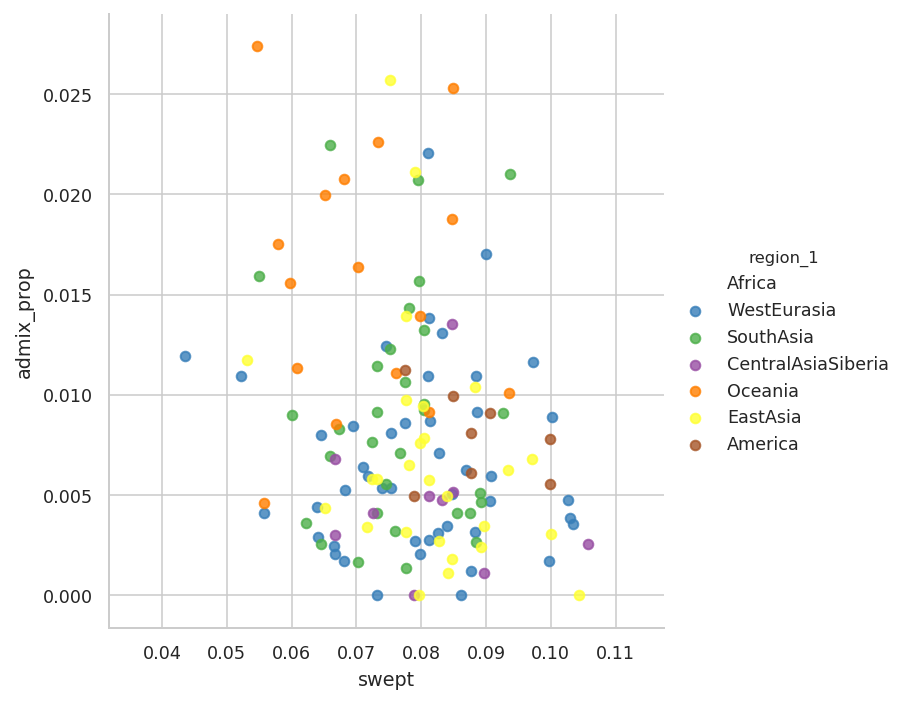

In [71]:
g = sns.lmplot(data=plot_df, 
               x='swept', y='admix_prop', hue='region_1', 
               fit_reg=False, palette='Set1')

## Admixture proportions across the X chromosome

Admixture and 75% regions:

In [72]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df.reset_index(inplace=True)
# plot_df = stairs(plot_df)
# plot_df.head()

win_means = merged_data.loc[~merged_data.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means['prop_swept'] = win_means.nr_swept / win_means.nr_total
win_means.reset_index(inplace=True)

win_means.head()

start      end  admix_prop  admix_prop_not_sweept  nr_swept  nr_total  \
0  2700000  2800000         NaN                    NaN       0.0       139   
1  2800000  2900000         NaN                    NaN       0.0       140   
2  2900000  3000000         NaN                    NaN       0.0       140   
3  3000000  3100000         NaN                    NaN       0.0       140   
4  3100000  3200000         NaN                    NaN       0.0       140   

   prop_swept  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

## Proportional reduction in admixture versus proportion swept

SpearmanrResult(correlation=-0.9999978320793719, pvalue=0.0)

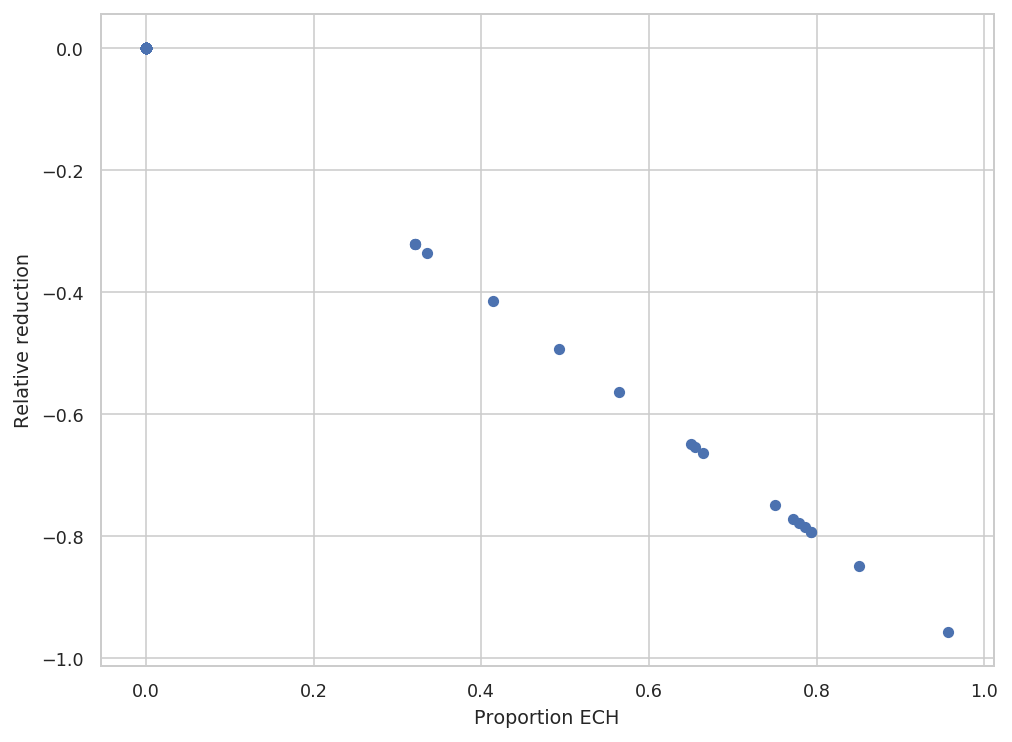

In [73]:
plt.figure(figsize=(8, 6))
plot_df = win_means.loc[win_means.admix_prop_not_sweept > 0]
plt.scatter(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept) ;
plt.xlabel("Proportion ECH")
plt.ylabel("Relative reduction")
scipy.stats.spearmanr(plot_df.prop_swept, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)

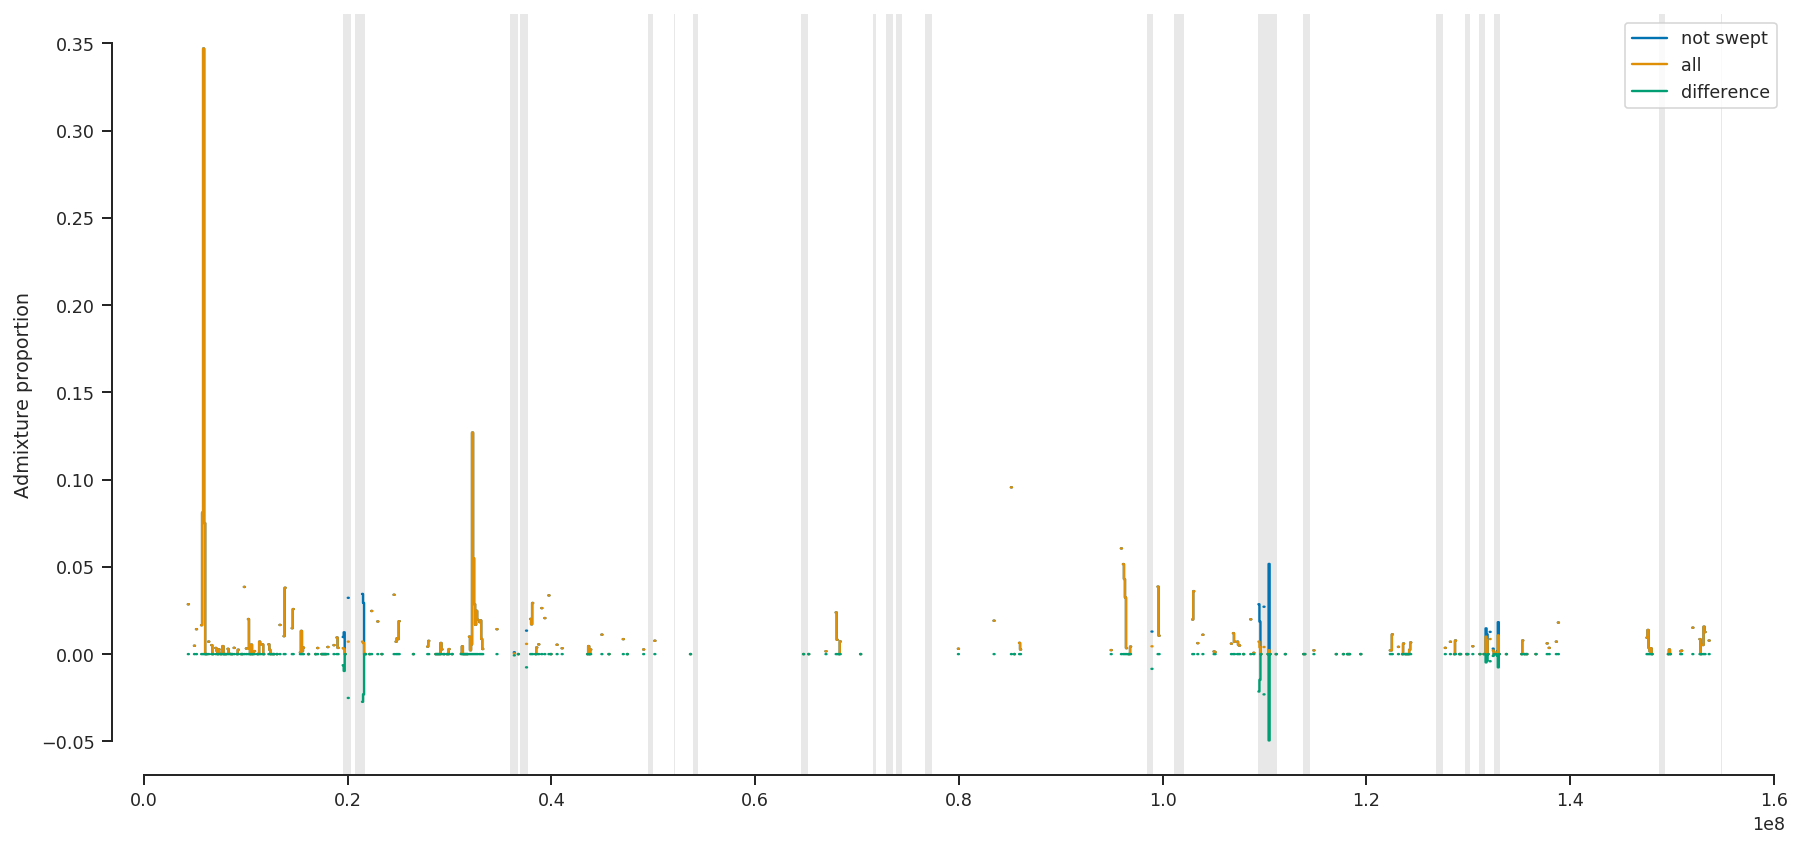

In [74]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_75.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            
        sns.despine(trim=True)

## Relative reduction in regions with sweeps 

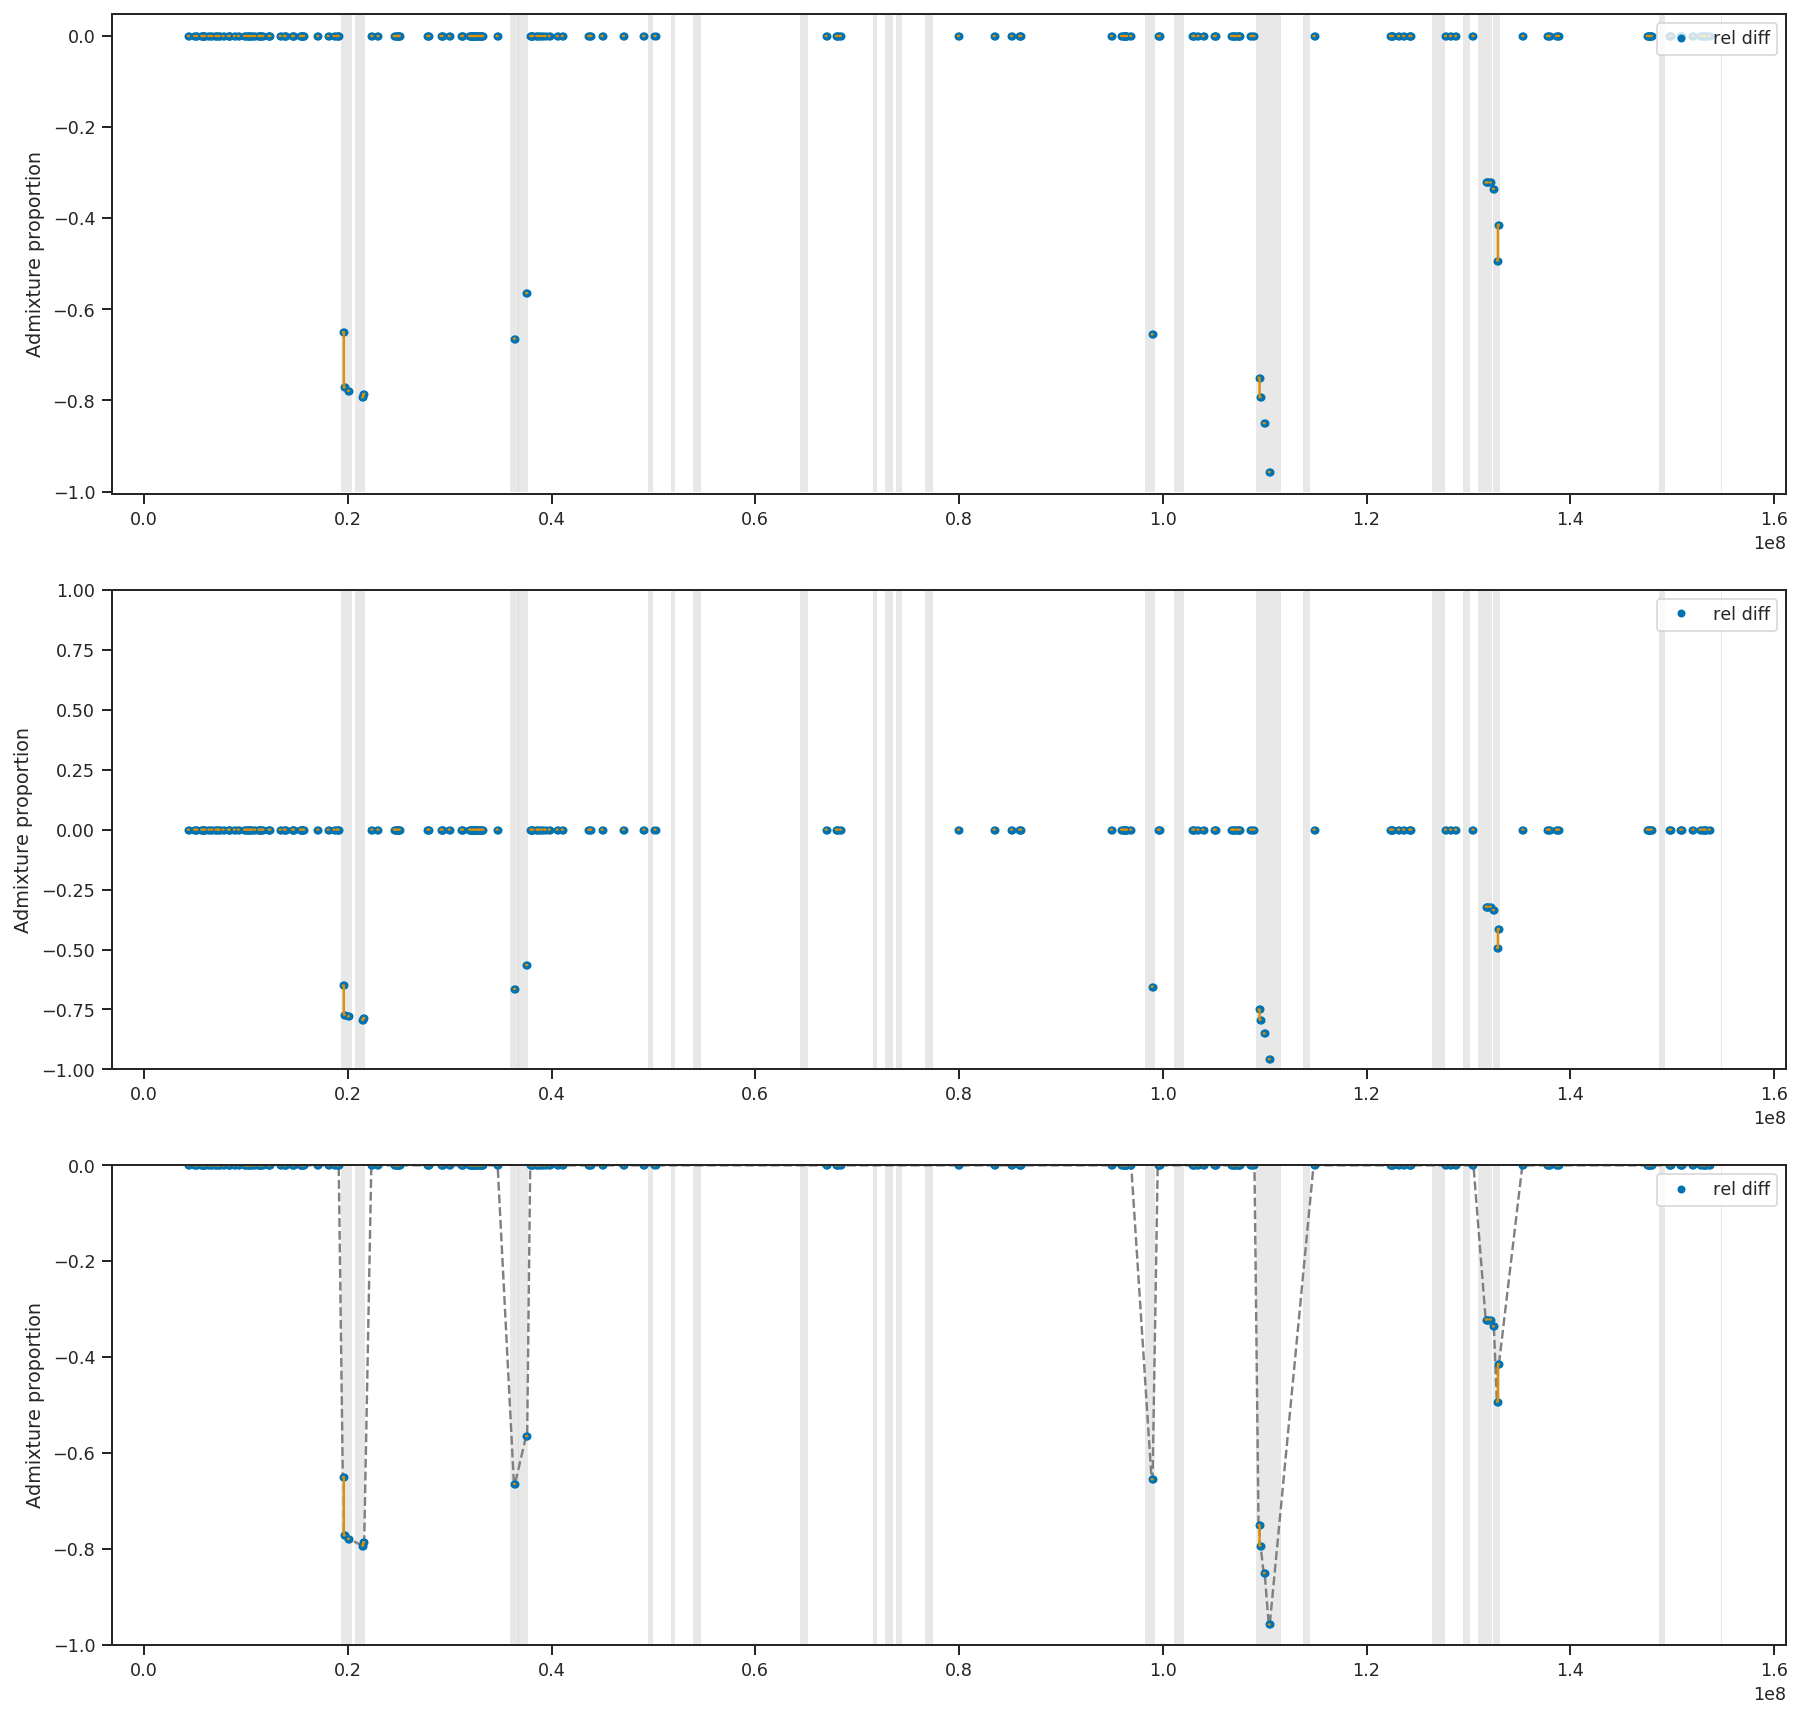

In [75]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        y = -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
        
        ax1.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, y)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, y, label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, y)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 8, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
        ax2.set_ylim(-1, 1)
        
        ax3.plot(plot_df.pos.loc[numpy.isfinite(y)], y.loc[numpy.isfinite(y)], color='grey', linestyle='dashed')
        ax3.plot(plot_df.pos, y, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax3.plot(plot_df.pos, y)


        ax3.legend(loc='upper right')
        ax3.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax3.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax3.set_ylim(-1, 0)

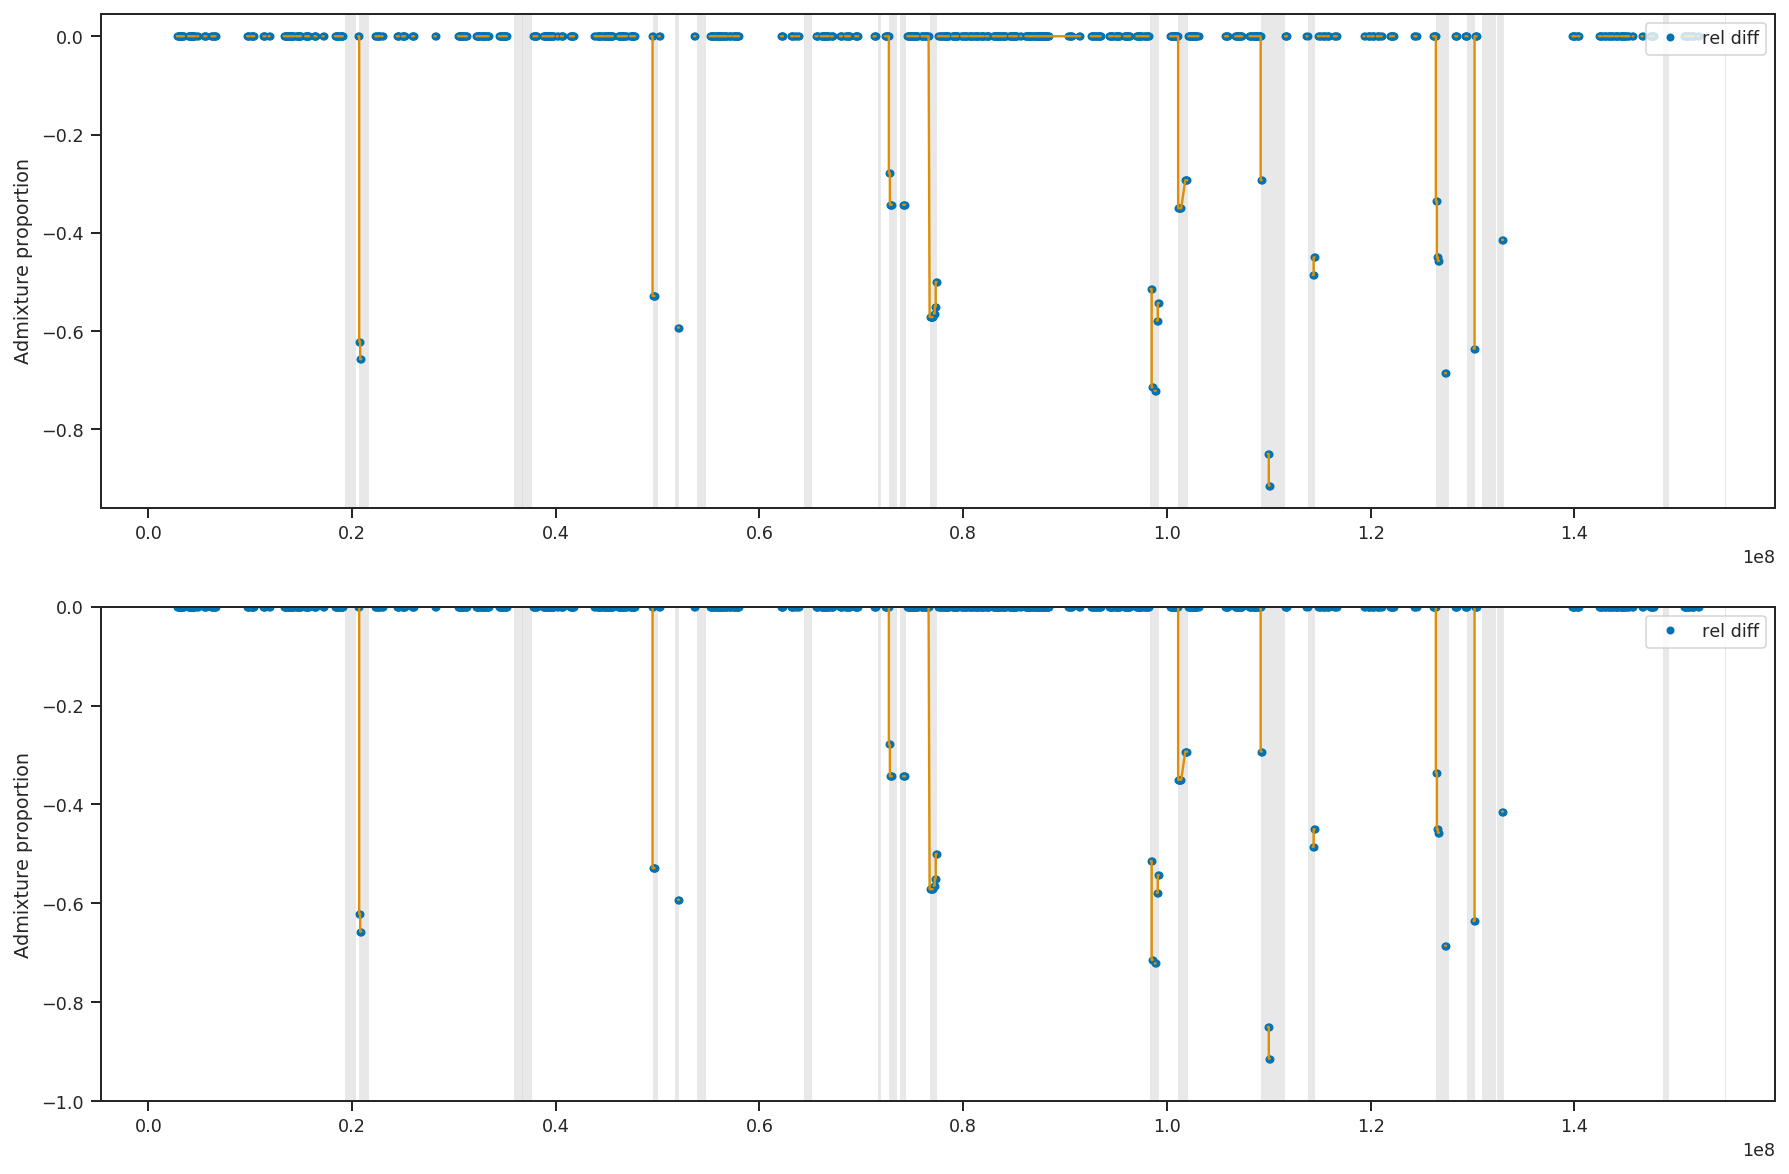

In [76]:
win_means_full = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']),
                    ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
win_means_full['admix_prop_not_sweept'] = merged_data_full.loc[(merged_data_full.swept == False) & ~merged_data_full.region_1.isin(['Africa']), 
                      ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
win_means_full['nr_swept'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
win_means_full['nr_total'] = merged_data_full.loc[~merged_data_full.region_1.isin(['Africa']), 
                      ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
win_means_full['prop_swept'] = win_means_full.nr_swept / win_means_full.nr_total
win_means_full.reset_index(inplace=True)

win_means_full.head()

plot_df = stairs(win_means_full)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax1.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept, 
                 label='rel diff', marker='o', markersize=3, linestyle='none')
        ax2.plot(plot_df.pos, -(plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop_not_sweept)
        ax2.legend(loc='upper right')
        ax2.set_ylabel('Admixture proportion')

        for tup in extended_peak_regions_10.itertuples():
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

#        sns.despine(trim=True)
        ax2.set_ylim(-1, 0)

**NB: set plot_df back to analysis without repeats:**

In [77]:
plot_df = stairs(win_means)

In [78]:
# plot_df = merged_data.loc[~merged_data.region_1.isin(['Africa']),
#                     ['admix_prop', 'start', 'end']].groupby(['start', 'end']).mean()
# plot_df['admix_prop_not_sweept'] = merged_data.loc[(merged_data.swept == False) & ~merged_data.region_1.isin(['Africa']), 
#                       ['admix_prop', 'start', 'end']].groupby(['start', 'end']).admix_prop.mean()
# plot_df['nr_swept'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.sum()
# plot_df['nr_total'] = merged_data.loc[~merged_data.region_1.isin(['Africa']), 
#                       ['swept', 'start', 'end']].groupby(['start', 'end']).swept.size()
# plot_df['prop_swept'] = plot_df.nr_swept / plot_df.nr_total
# plot_df.reset_index(inplace=True)
# #plot_df = stairs(plot_df)
# plot_df.head()

Admixture and ILS, ampl. regions and 10% regions:

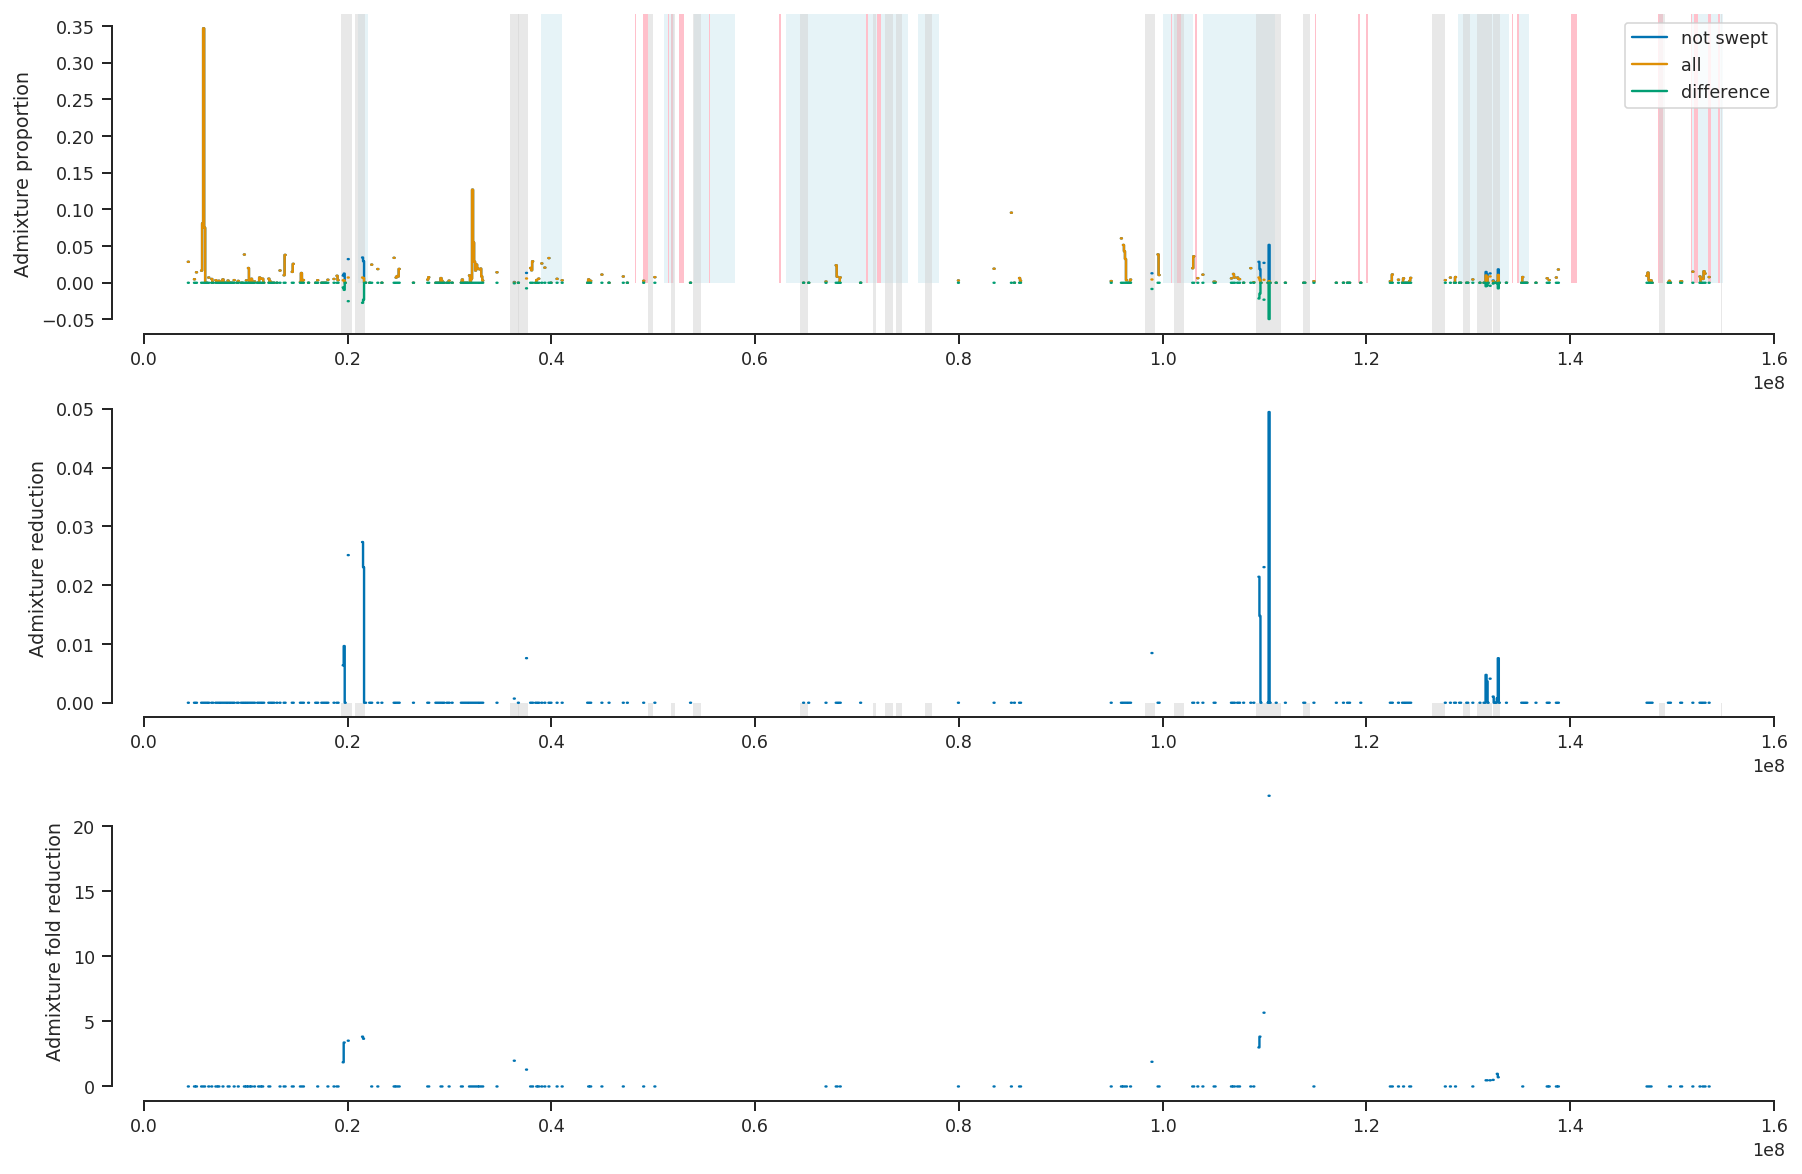

In [79]:
plot_df = stairs(win_means)

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
        ax1.plot(plot_df.pos, plot_df.admix_prop_not_sweept, label='not swept')
        ax1.plot(plot_df.pos, plot_df.admix_prop, label='all')
        ax1.plot(plot_df.pos, plot_df.admix_prop - plot_df.admix_prop_not_sweept, label='difference')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Admixture proportion')
        
        ax2.plot(plot_df.pos, plot_df.admix_prop_not_sweept - plot_df.admix_prop)
        ax2.set_ylabel('Admixture reduction')

        ax3.plot(plot_df.pos, (plot_df.admix_prop_not_sweept - plot_df.admix_prop)/plot_df.admix_prop)
        ax3.set_ylabel('Admixture fold reduction')

        for tup in extended_peak_regions_10.itertuples():
            g = ax1.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))
            g = ax2.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 1, 
                 facecolor='lightgray', 
                 linewidth=0,
        #              edgecolor=None,
                 alpha=0.5,
                 zorder=1))
            
        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='lightblue',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax1.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='pink',
                         linewidth=0,
                         alpha=1,
                         zorder=0))            
            
            
        sns.despine(trim=True)
#mpld3.display() 

In [80]:
#mpld3.display(fig)        

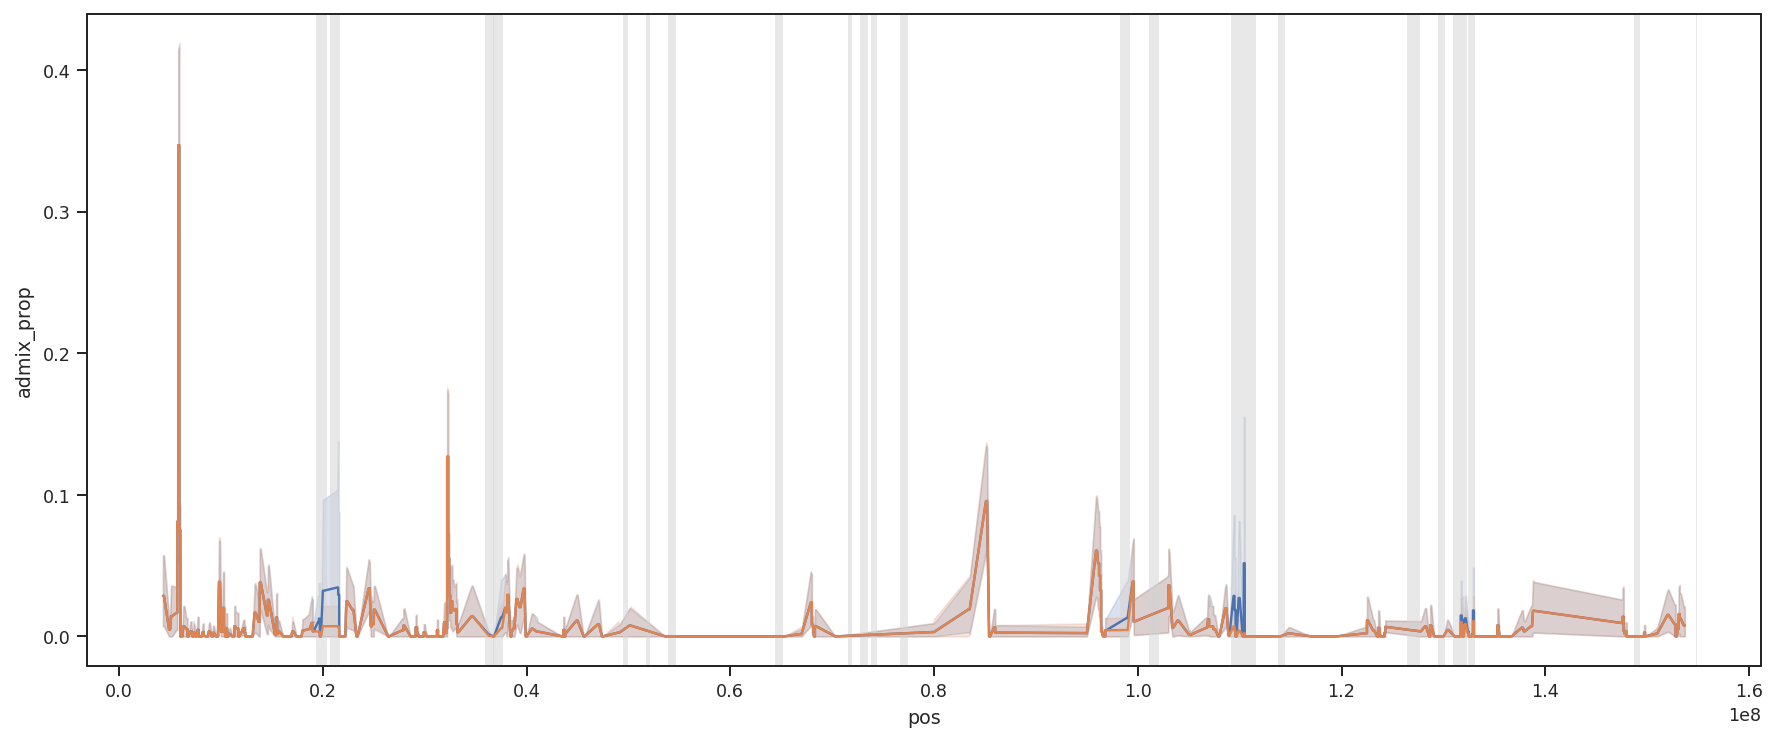

In [81]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))

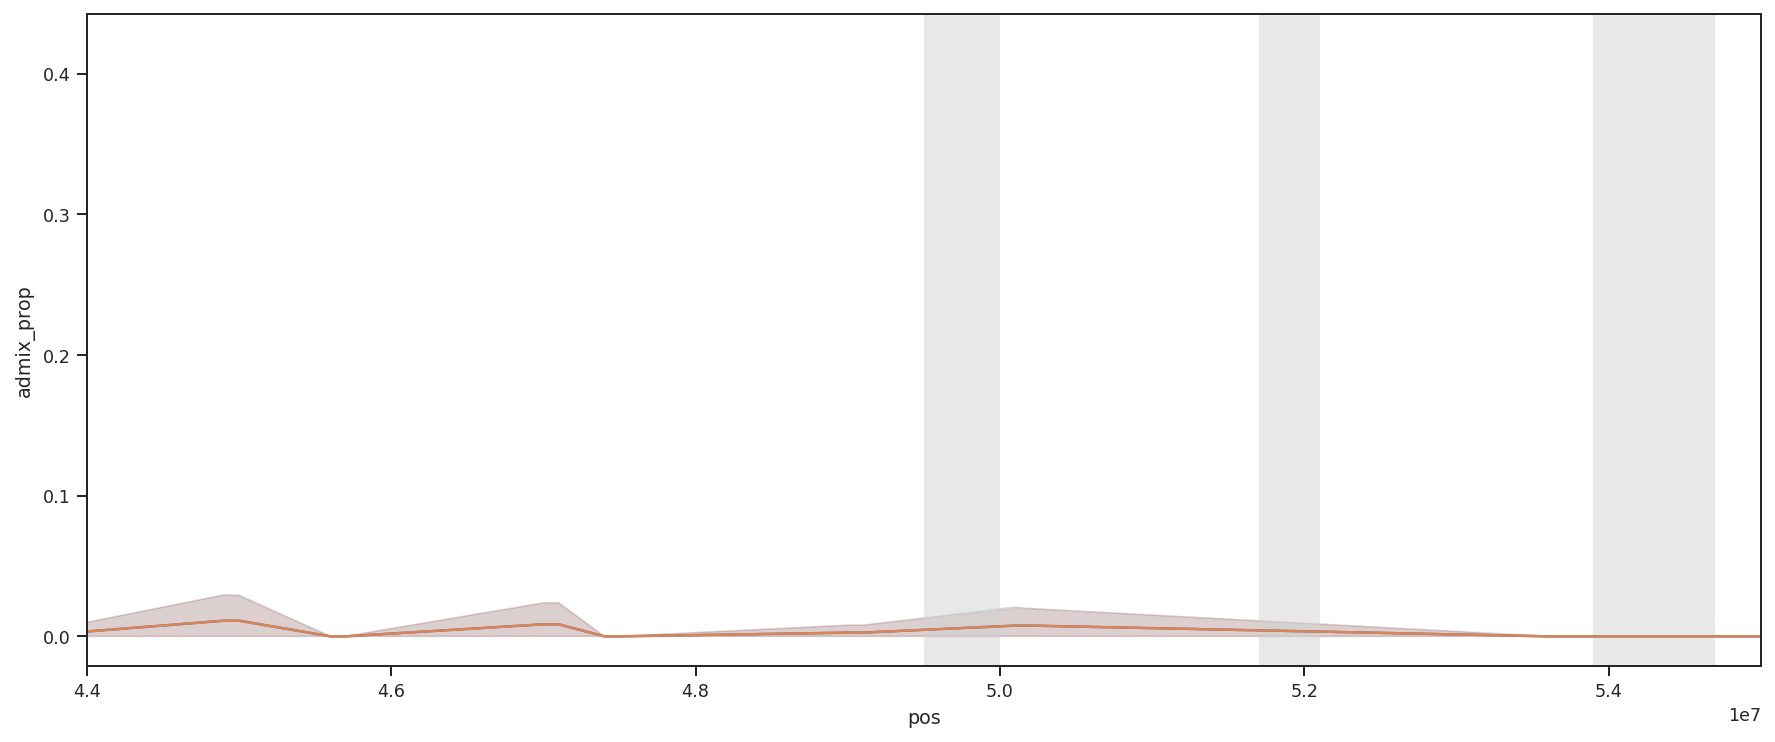

In [82]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(44e6, 55e6)

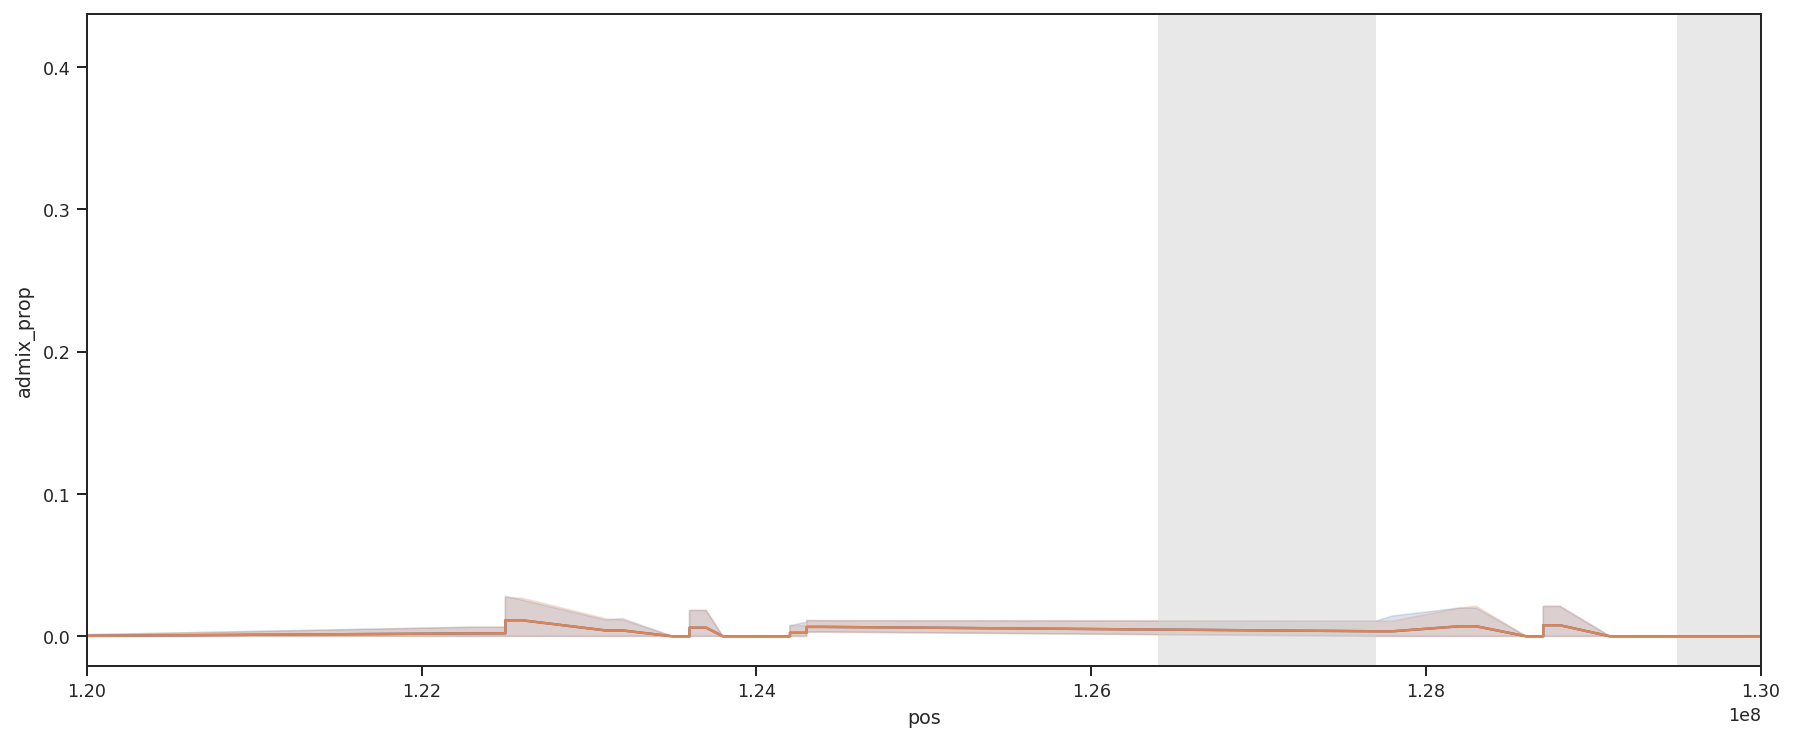

In [83]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_xlim(120e6, 130e6)

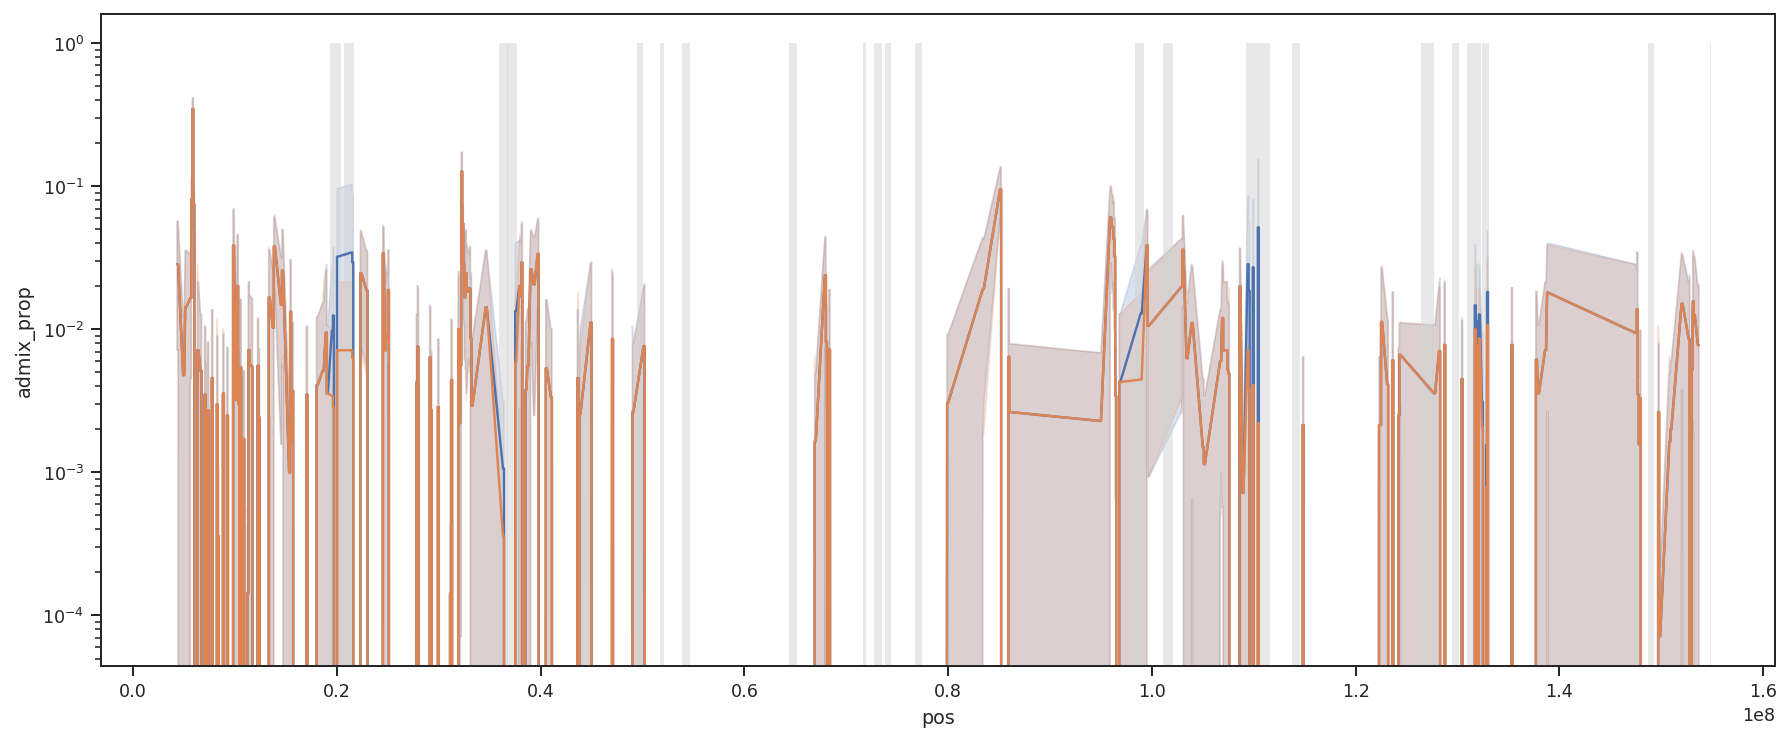

In [84]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(15,6))
    plot_df = stairs(merged_data.loc[merged_data.swept == False], endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop)
    plot_df = stairs(merged_data, endtrim=1)
    ax = sns.lineplot(plot_df.pos, plot_df.admix_prop) ;

    for tup in extended_peak_regions_10.itertuples():
        ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', linewidth=0, alpha=0.5, zorder=1))
    ax.set_yscale('log')

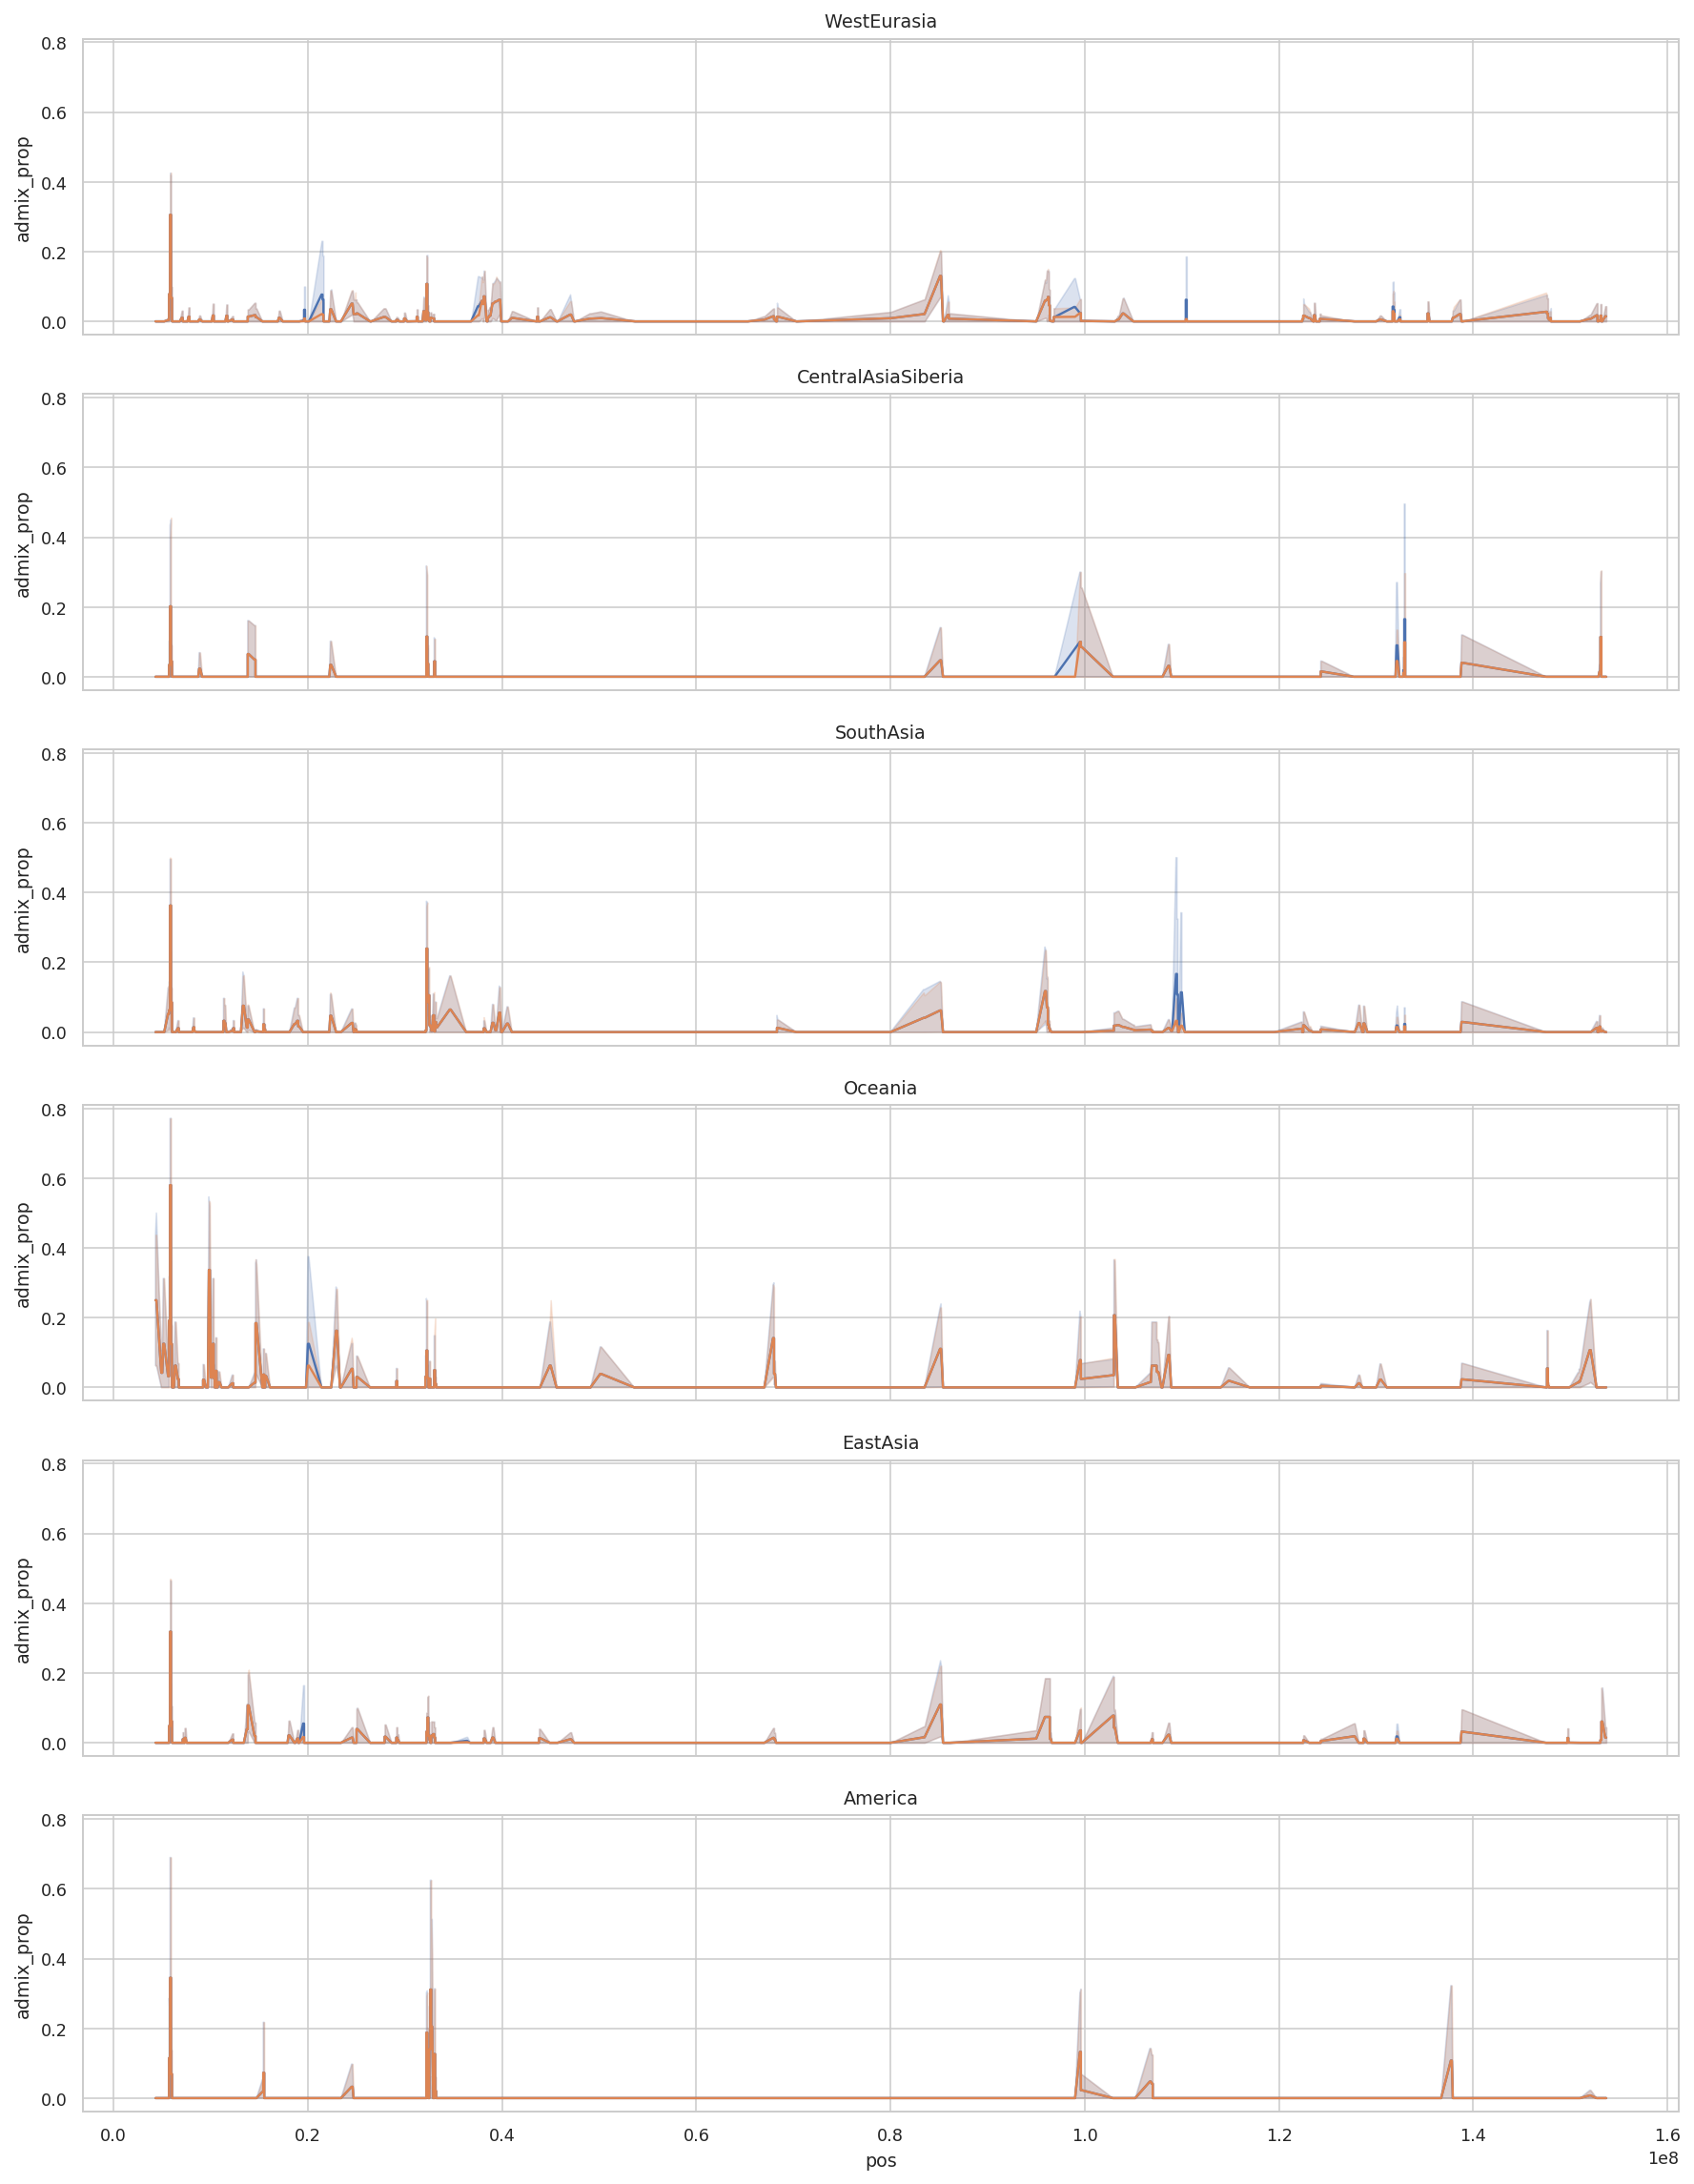

In [85]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.admix_prop, ax=axes[i])

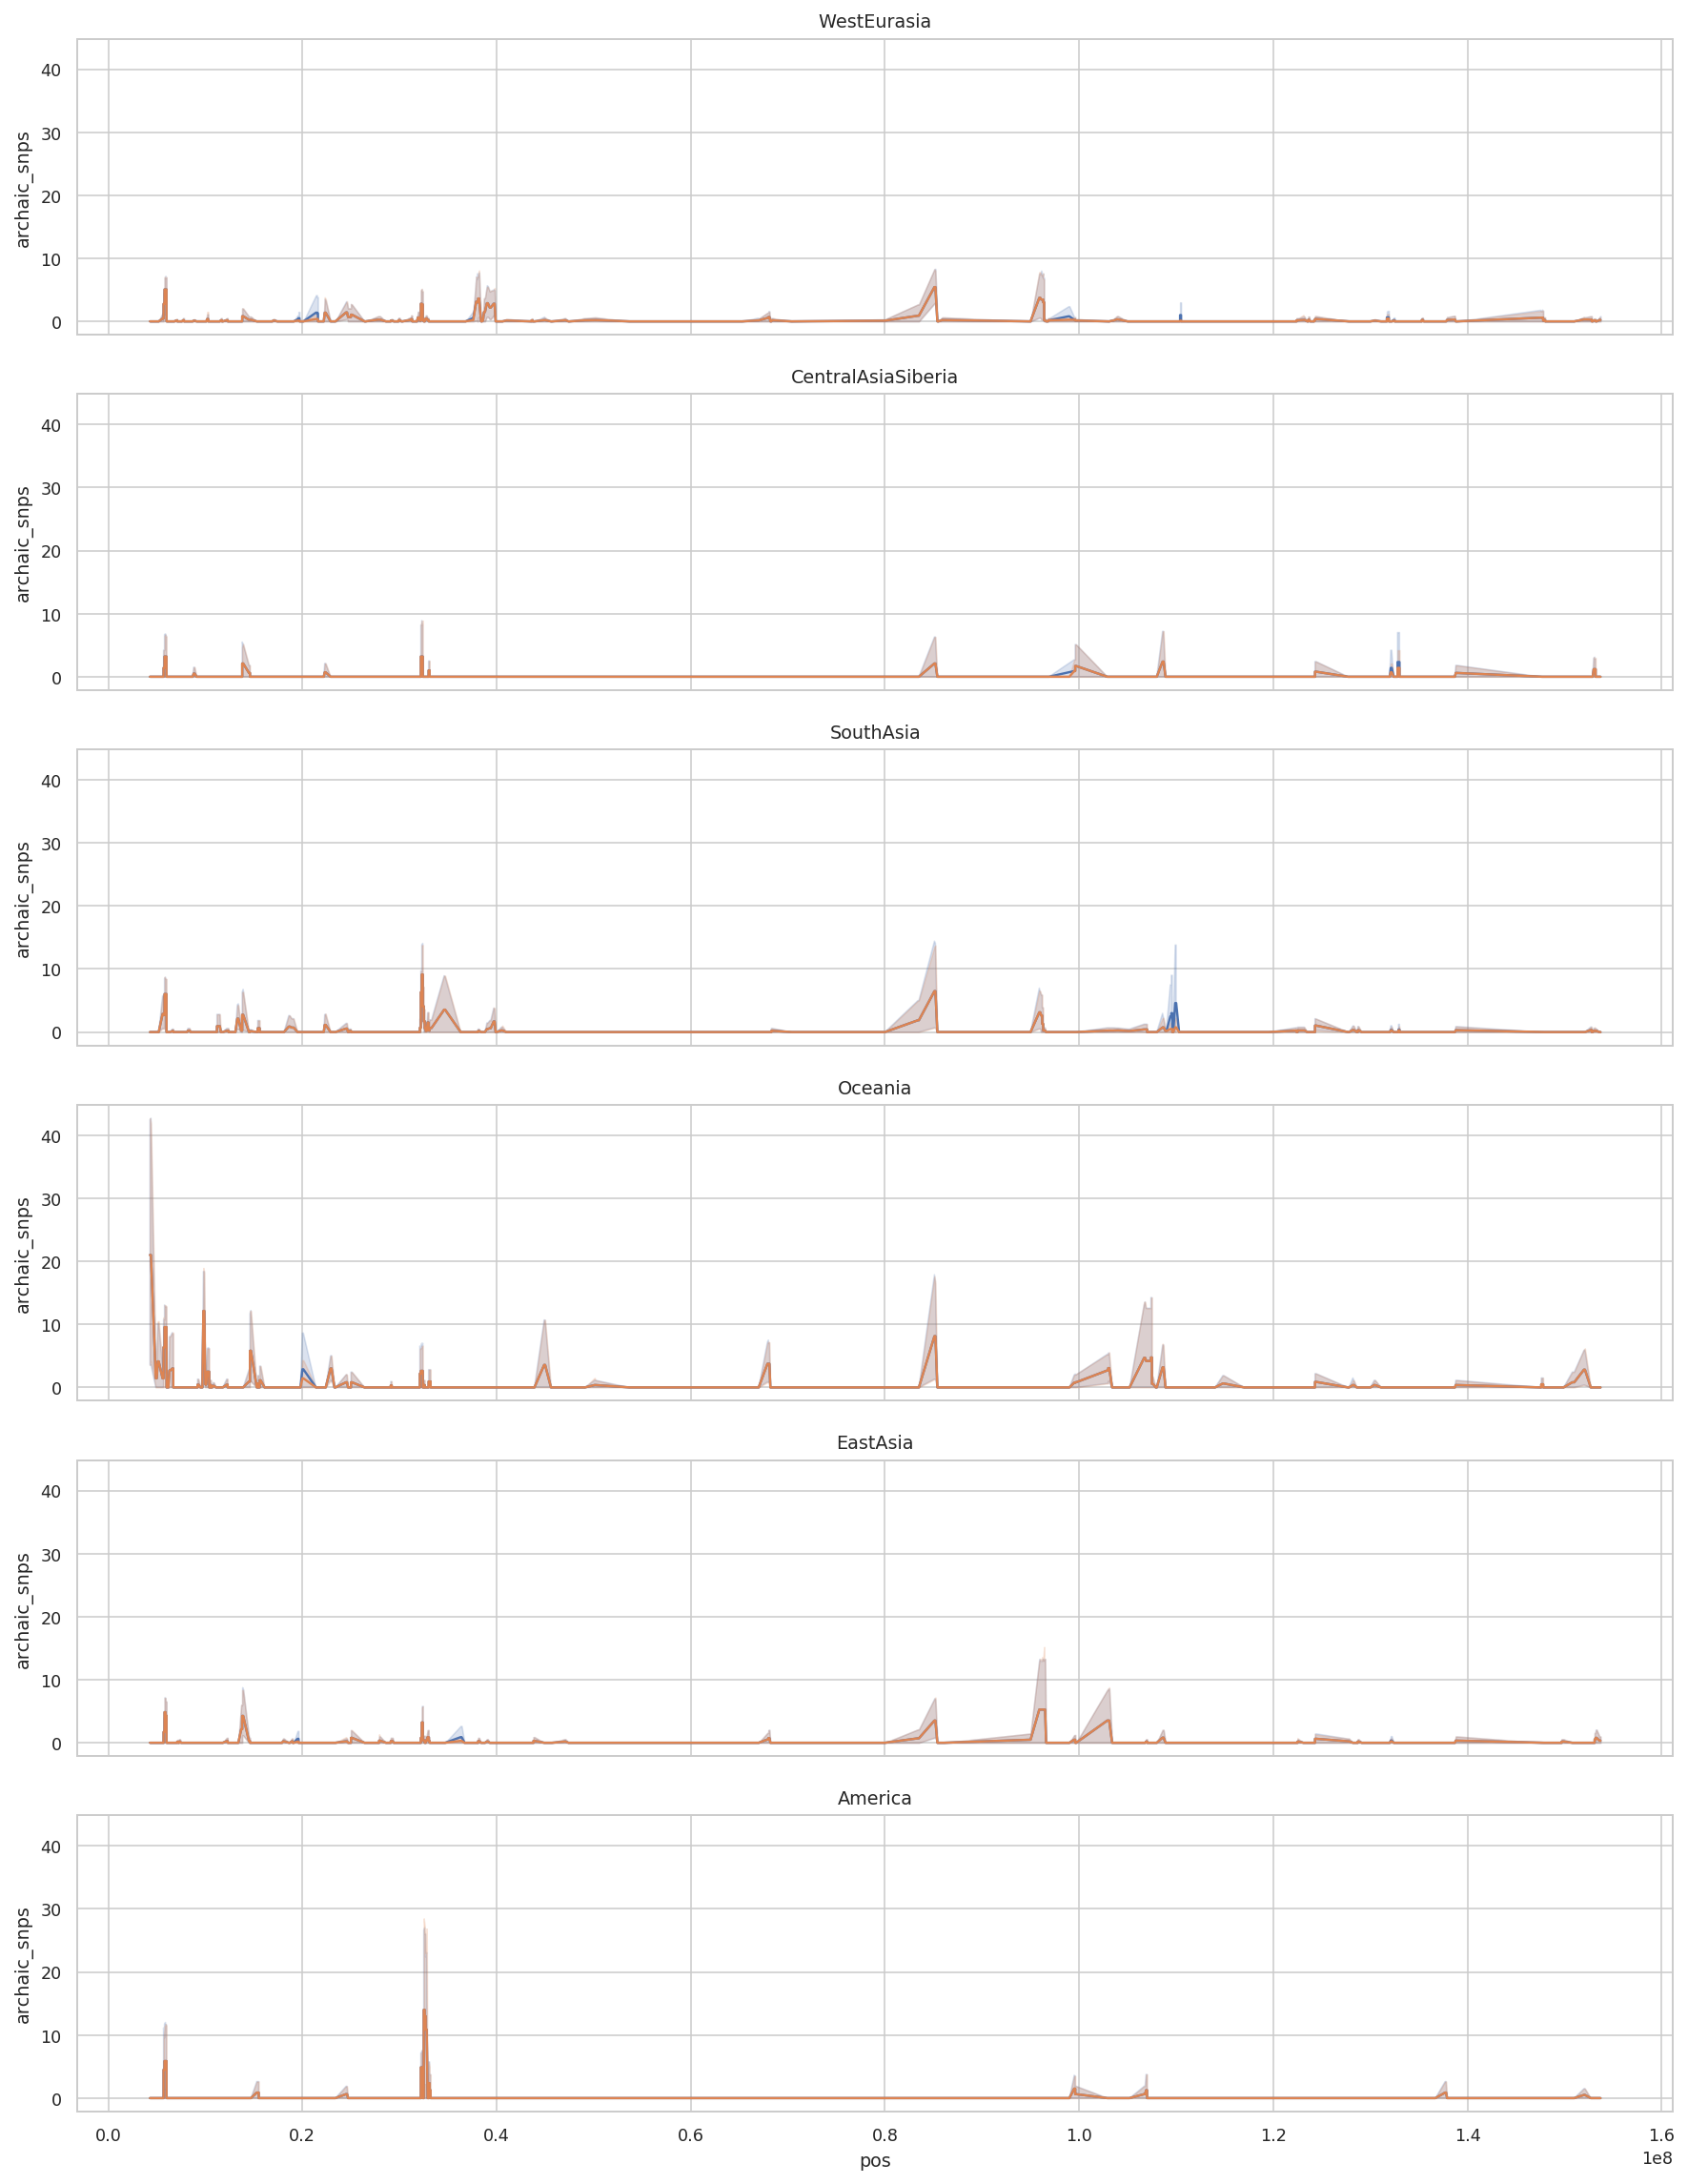

In [86]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.archaic_snps, ax=axes[i])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2adbc1036f28> (for post_execute):


KeyboardInterrupt: 

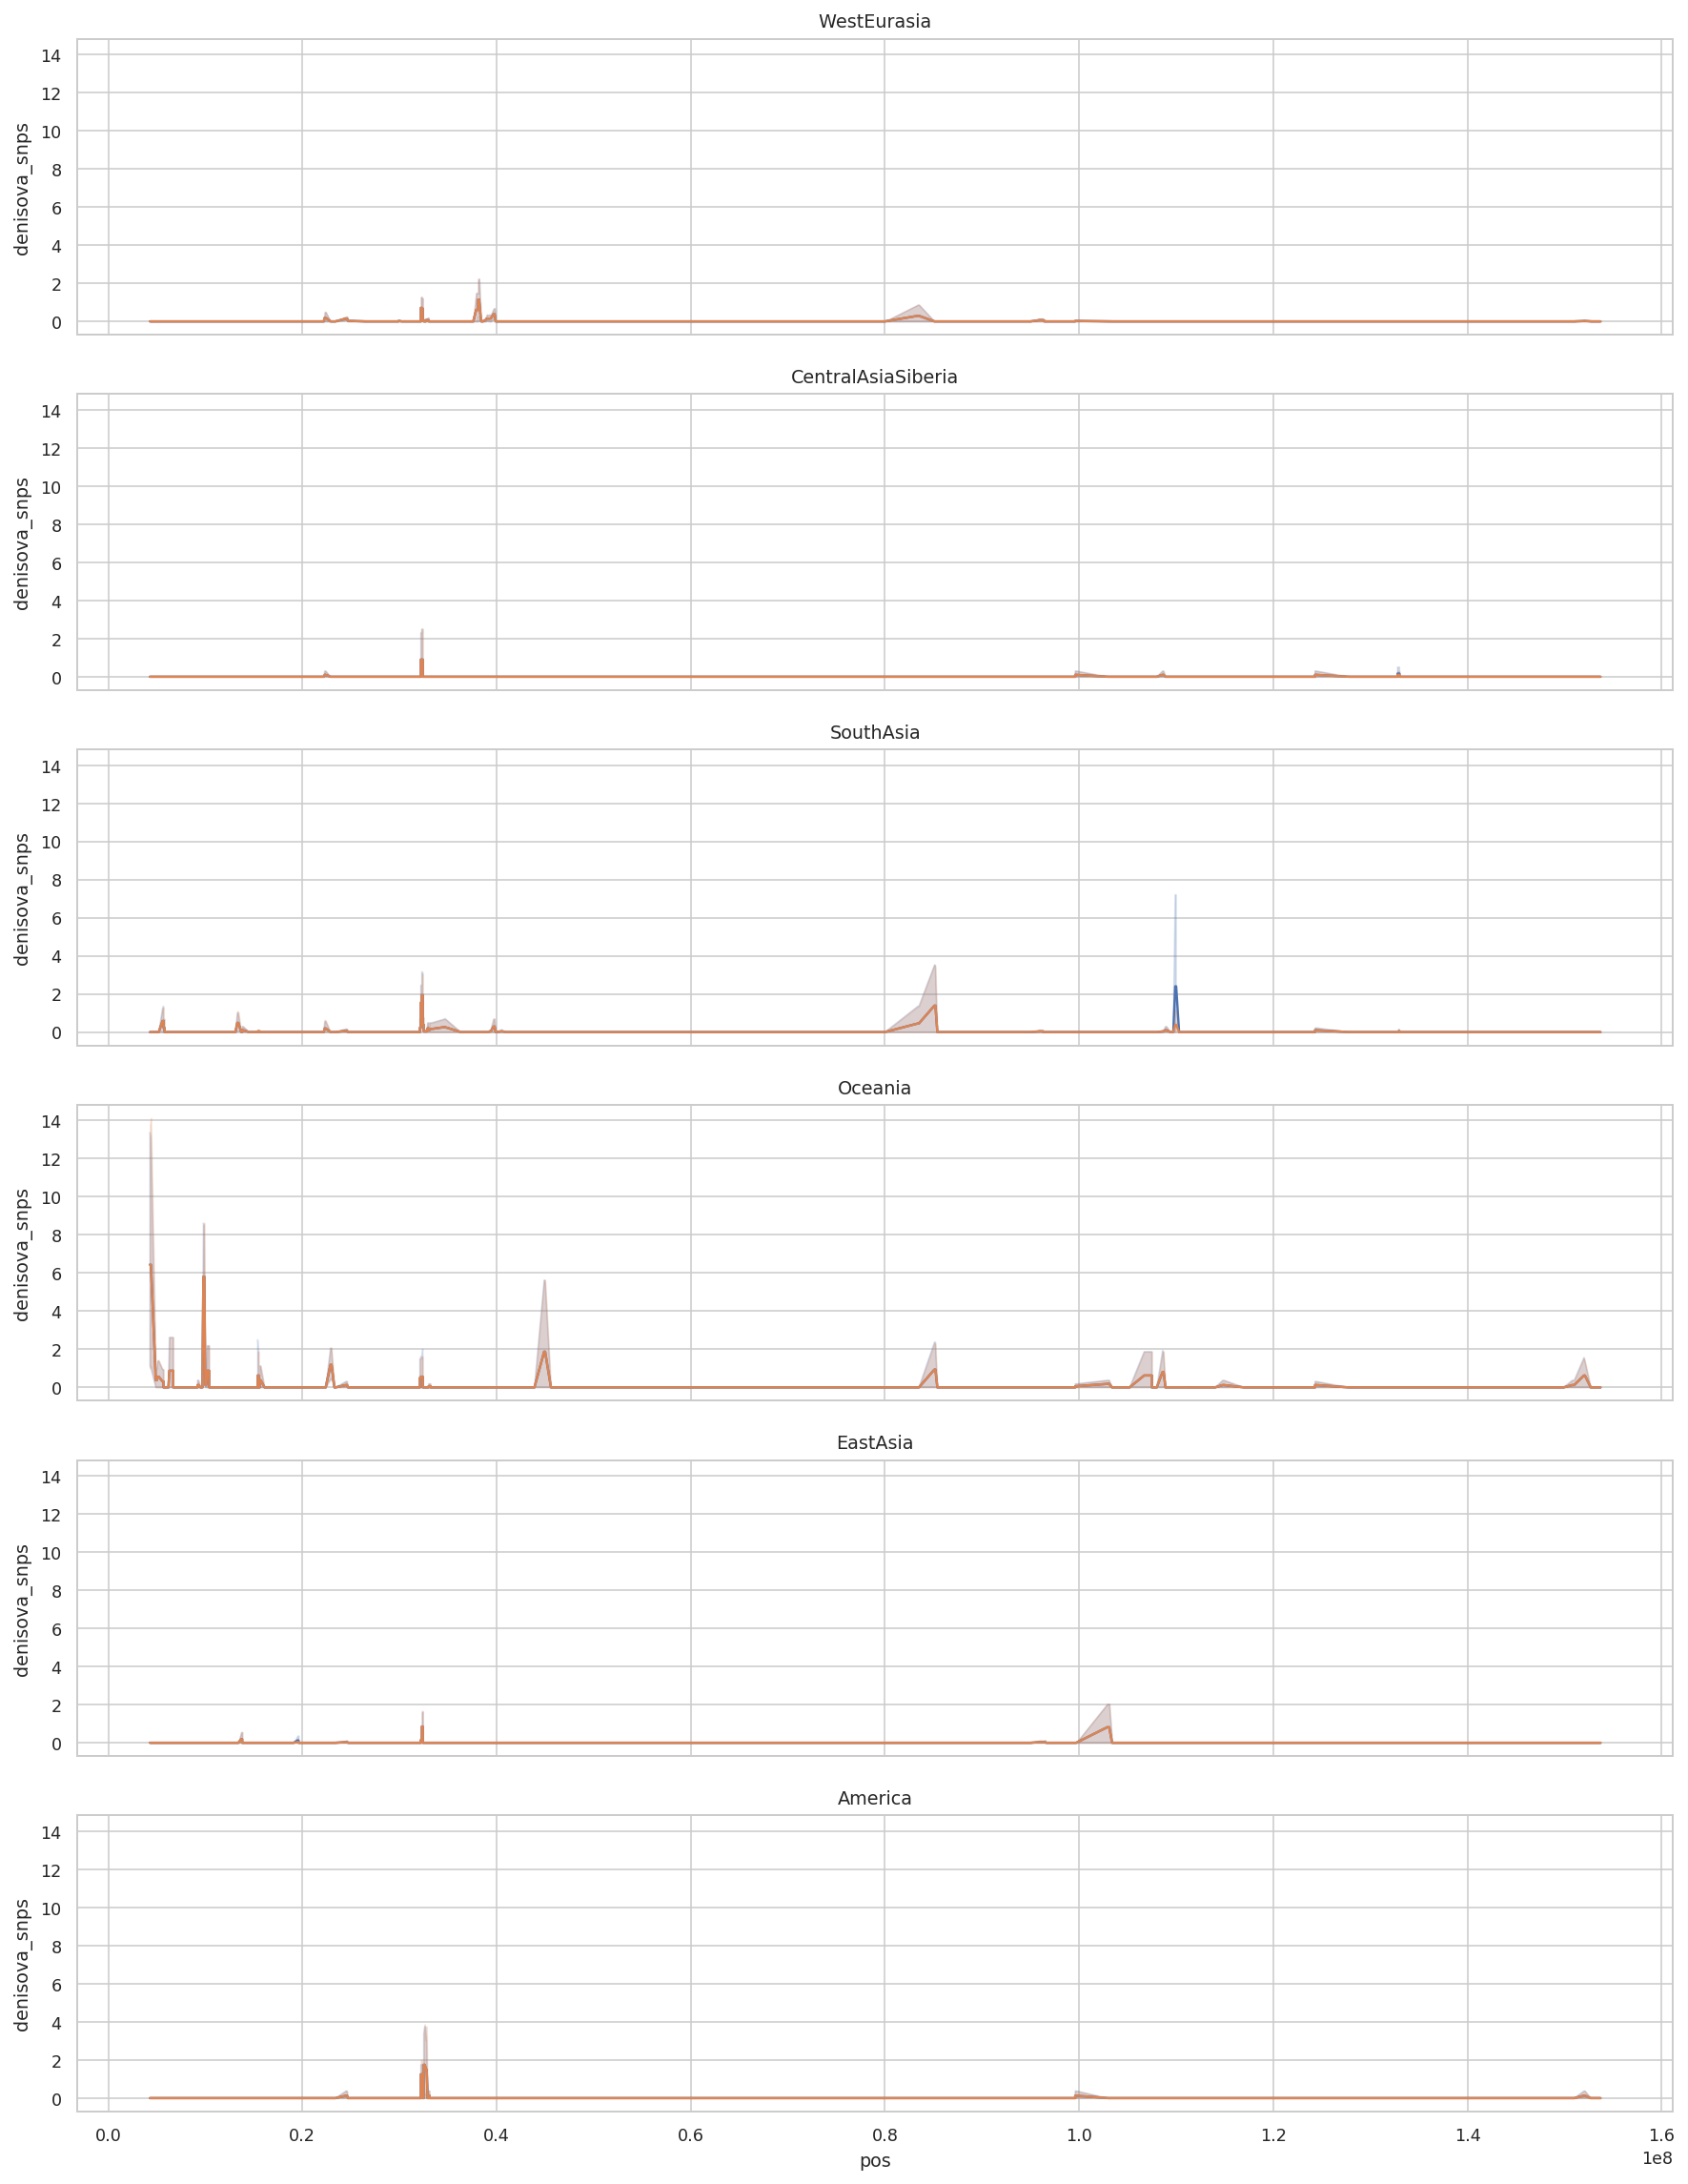

In [87]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.denisova_snps, ax=axes[i])

In [88]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-fd1d4a62ff45>", line 4, in <module>
    sns.lineplot(df.pos, df.altai_snps, ax=axes[i])
  File "/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/seaborn/relational.py", line 1084, in lineplot
    p.plot(ax, kwargs)
  File "/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/seaborn/relational.py", line 775, in plot
    x, y, y_ci = self.aggregate(y, x, units)
  File "/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/seaborn/relational.py", line 718, in aggregate
    cis = grouped.apply(bootstrapped_cis)
  File "/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/pandas/core/groupby.py", line 3112, in apply
    return super(SeriesGroupBy, self).apply(func, *args, **kwargs)
  File "/home/kmt/anaconda3/envs/simons/l

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2adbc1111d08> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(15,20), sharex=True, sharey=True)
for i, region in enumerate(['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'Oceania', 'EastAsia', 'America']):
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region) & (merged_data.swept == False)], endtrim=1)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])
    df = stairs(merged_data.loc[(merged_data.region_label_1 == region)], endtrim=1)
    axes[i].set_title(region)
    sns.lineplot(df.pos, df.vindija_snps, ax=axes[i])

In [ ]:
# plt.figure(figsize=(20,5))
# #plt.plot(merged_data.start, merged_data.admix_prop)
# filtered = lowess(merged_data.admix_prop, merged_data.start, is_sorted=False, frac=0.001, it=0)
# plt.plot(filtered[:,0], filtered[:,1], color='orange')
# plt.show()